In [3]:
# Imported the libraries
import pandas as pd
import numpy as np
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
!pip install arch
from arch import arch_model
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
#Mounted Google Drive to Fetch Excel
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [5]:
# Loaded the Excel file and reading each sheet into a dictionary of DataFrames
file_path = '/content/drive/My Drive/FRM/Healthcare_Data_Final.xlsx'
excel_data = pd.ExcelFile(file_path)
stock_data = {sheet: excel_data.parse(sheet) for sheet in excel_data.sheet_names}
stock_data

{'Max Healthcare':           Date   Close    Open    High     Low    Volume
 0   2020-08-20  111.75  106.45  111.75  106.45    807716
 1   2020-08-24  111.95  117.30  129.30  111.95   4933970
 2   2020-08-31  115.25  107.20  120.90  101.10   3868840
 3   2020-09-07  131.55  115.65  133.95  105.60  14143610
 4   2020-09-14  116.85  127.00  129.35  115.25   7240437
 ..         ...     ...     ...     ...     ...       ...
 193 2024-04-29  813.45  763.05  854.30  762.35  10622103
 194 2024-05-06  811.40  820.00  835.85  782.25   8471287
 195 2024-05-13  846.45  805.00  852.30  783.05   9844818
 196 2024-05-21  789.40  805.00  867.50  784.40   8090010
 197 2024-05-27  751.80  789.95  817.50  743.10  12027919
 
 [198 rows x 6 columns],
 'Apollo Hospitals ':           Date    Close     Open     High      Low   Volume
 0   2018-04-02  1076.30  1066.00  1125.00  1056.00  1674689
 1   2018-04-09  1082.35  1098.00  1118.65  1051.60  1686698
 2   2018-04-16  1134.00  1082.40  1143.90  1069.30  14

This code defines a function to prepare data, clean and standardize each stock. It converts the Date column to datetime format, sets it as the index for time-series analysis and sorts the data. These steps ensure consistency making it suitable for time-series modeling and analysis. The function is applied to each stock preparing it for processing and ensuring that operations are based on dates.

In [6]:
# Clean and prepare data
def prepare_data(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df.sort_index(inplace=True)
    return df

for stock in stock_data:
    stock_data[stock] = prepare_data(stock_data[stock])

We are using GARCH (Generalized Autoregressive Conditional Heteroskedasticity) model to analyze and visualize the volatility of each stock's returns. The function is calculating the daily returns based on the stock’s closing prices, then applying the model to capture periods of high and low volatility.
For each stock, we generate a time series of conditional volatility, which represents the model’s estimate of variability over time.The function then plots volatility to show how the stock's risk fluctuates.
Peaks in the plot indicate periods of high volatility mostly due to market stress or external shocks which make it useful for identifying potential risks for each stock.

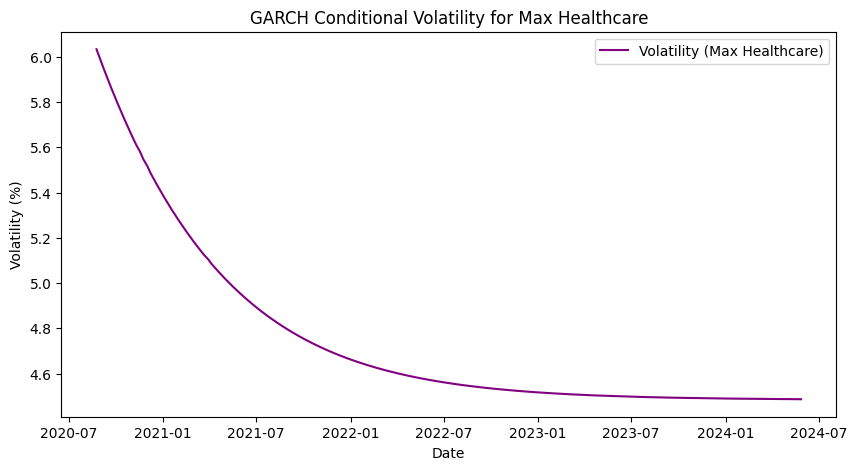

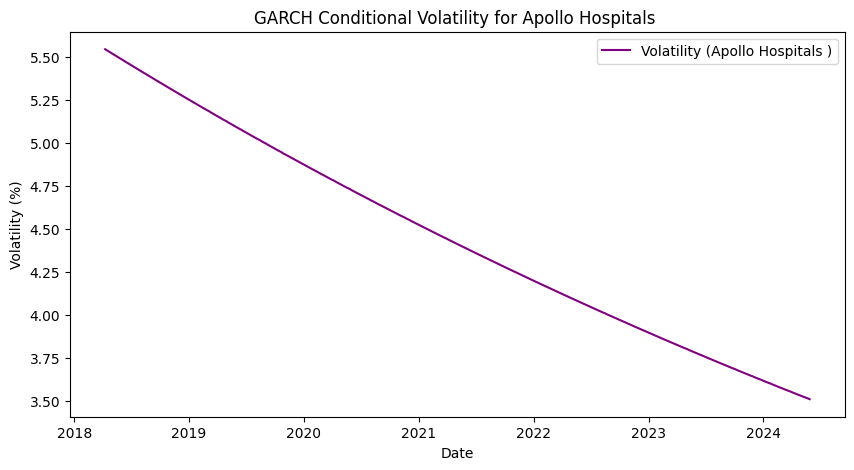

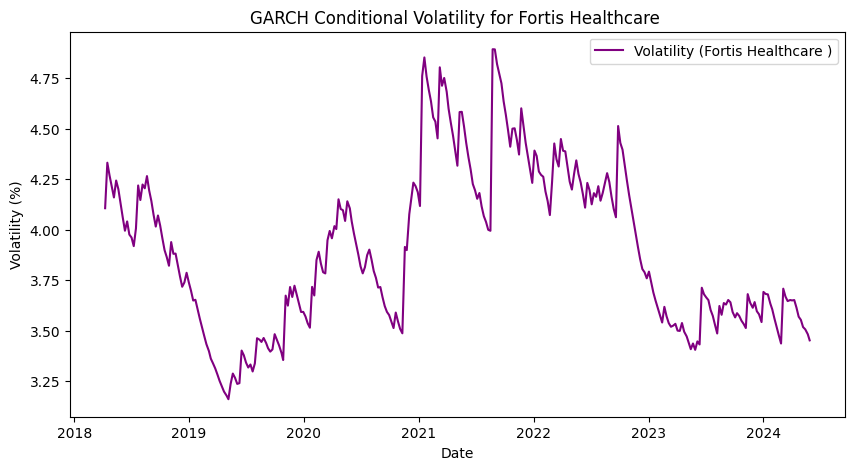

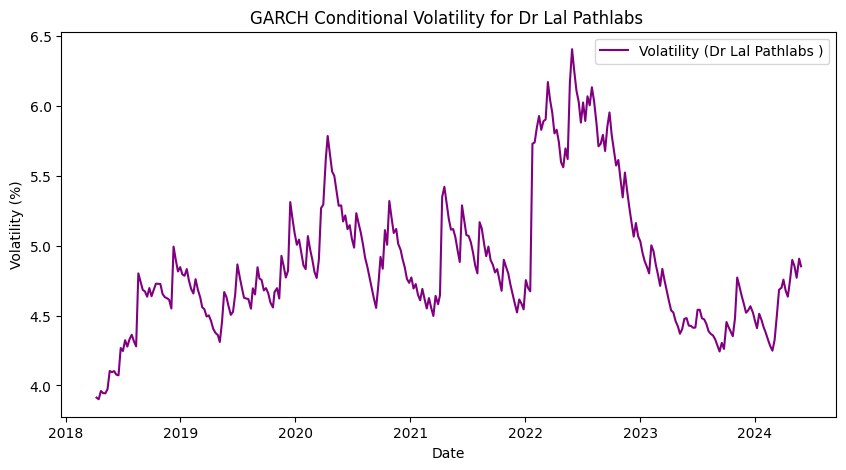

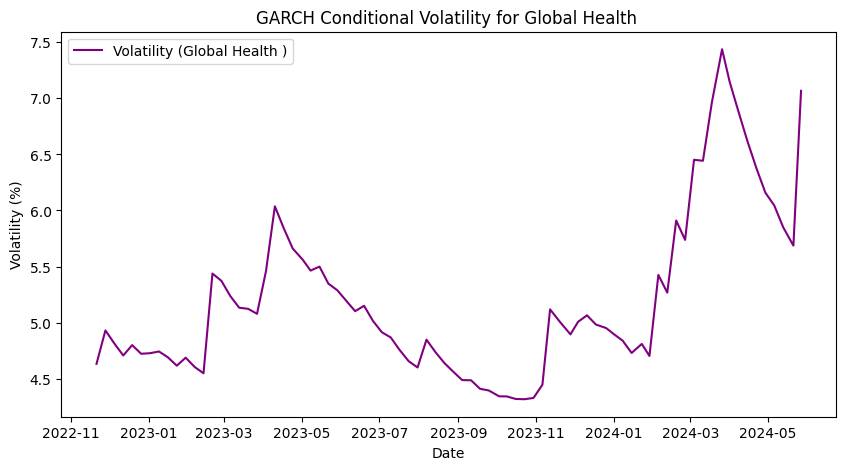

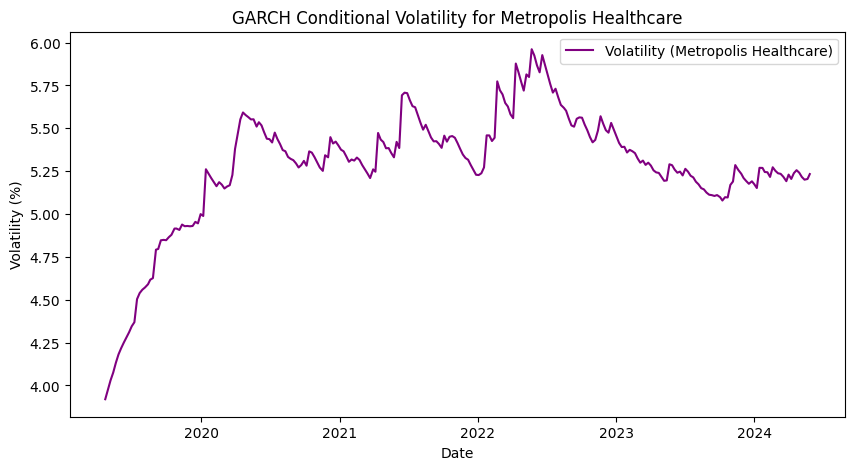

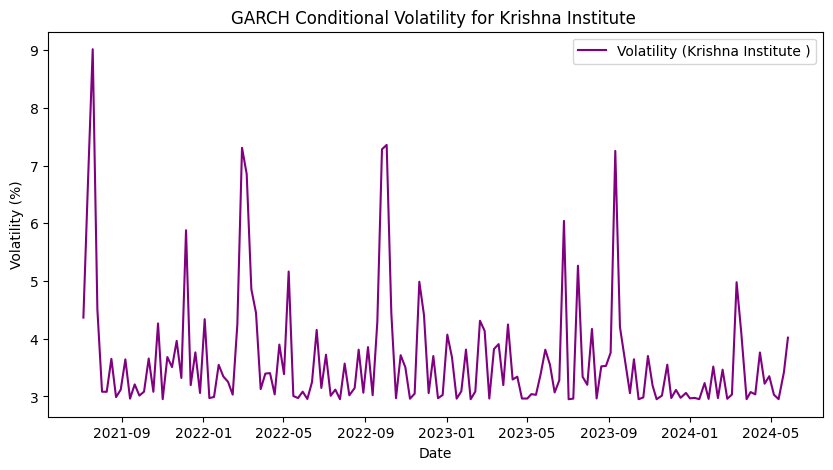

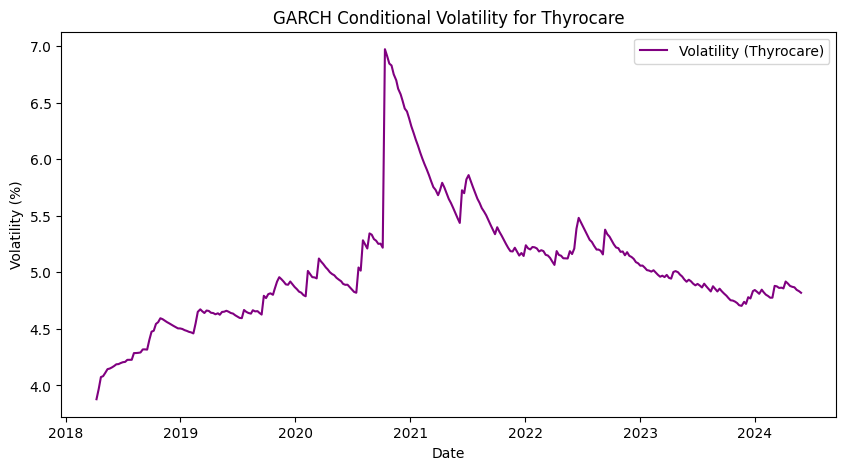

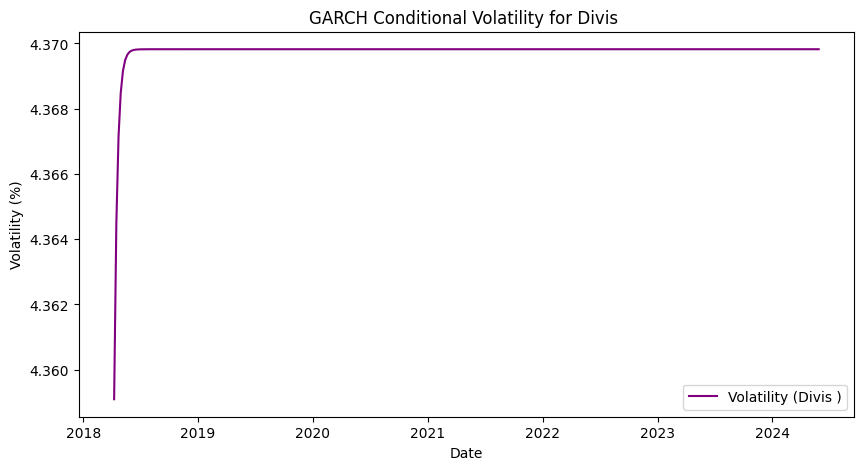

In [7]:
# GARCH Model for Volatility Analysis
def fit_garch(data):
    returns = data['Close'].pct_change().dropna() * 100
    model = arch_model(returns, vol='Garch', p=1, q=1)
    garch_result = model.fit(disp="off")
    return garch_result

# For each stock's data and plot volatility
for stock in stock_data:
    garch_result = fit_garch(stock_data[stock])
    volatility = garch_result.conditional_volatility

    plt.figure(figsize=(10, 5))
    plt.plot(volatility, label=f'Volatility ({stock})', color='purple')
    plt.title(f'GARCH Conditional Volatility for {stock}')
    plt.xlabel('Date')
    plt.ylabel('Volatility (%)')
    plt.legend()
    plt.show()

We performed the Monte Carlo simulation to model potential future price paths for each stock. The function generates simulated stock prices by iterating through multiple hypothetical price paths (based on a specified starting price, average daily return, and volatility). For each stock 1000 simulations are run over 252 trading days creating a matrix of simulated paths. We have then visualized the first 100 simulated paths to provide an overview of potential future price variations. This helps illustrate the range of possible outcomes and the uncertainty in stock prices which is important in assessing risk and understanding probable price fluctuations under different scenarios.

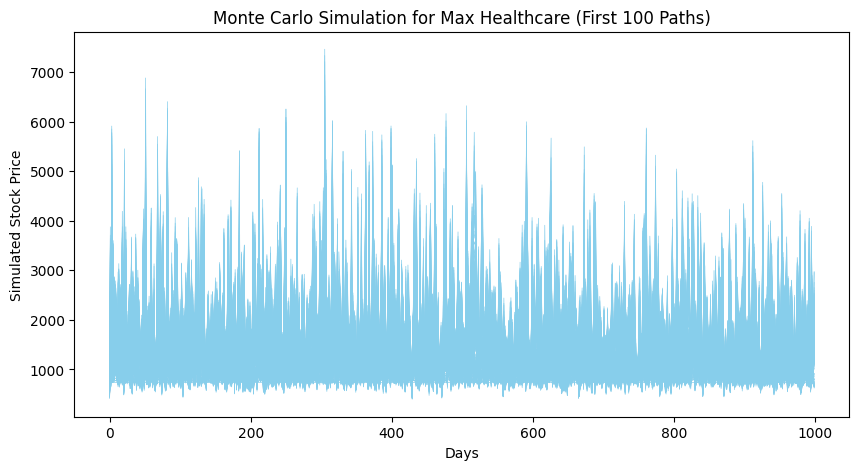

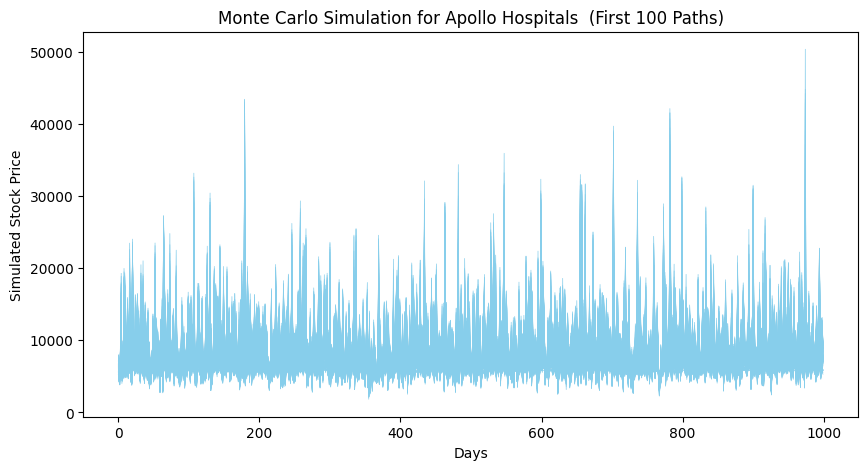

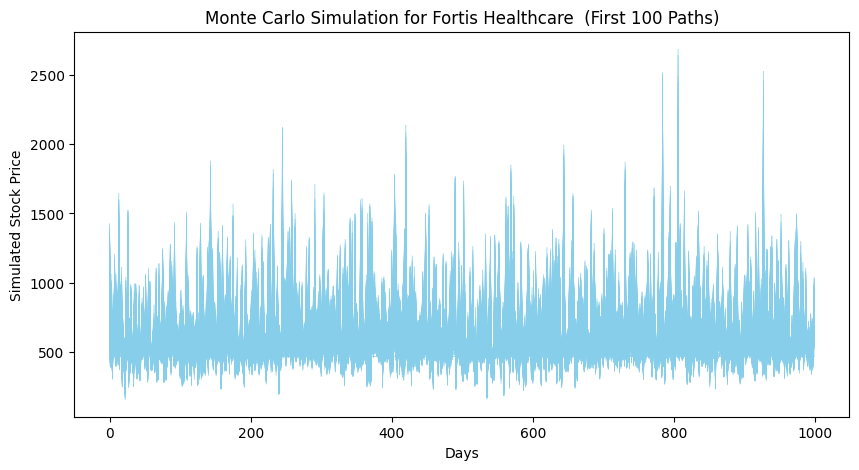

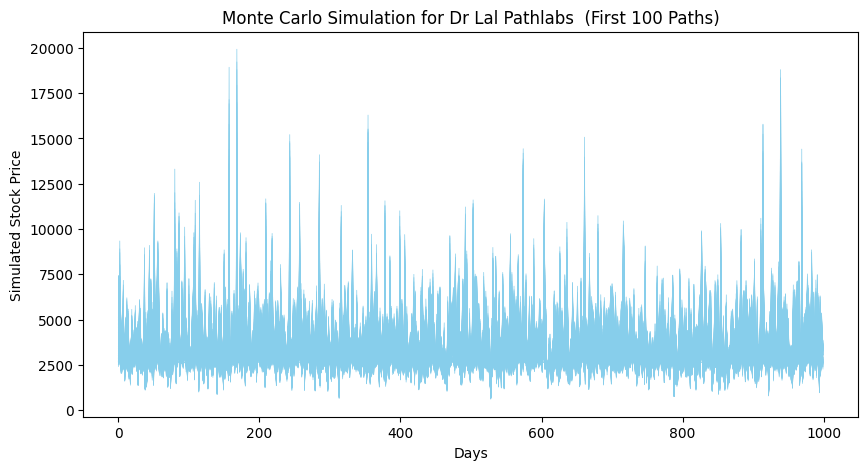

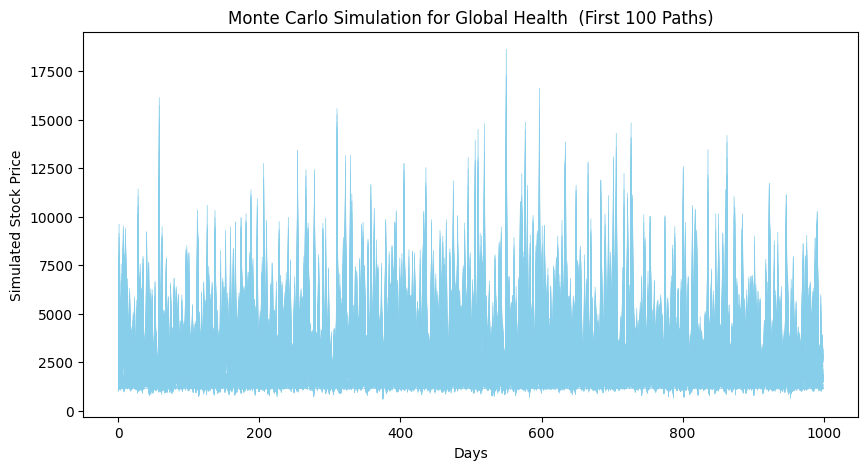

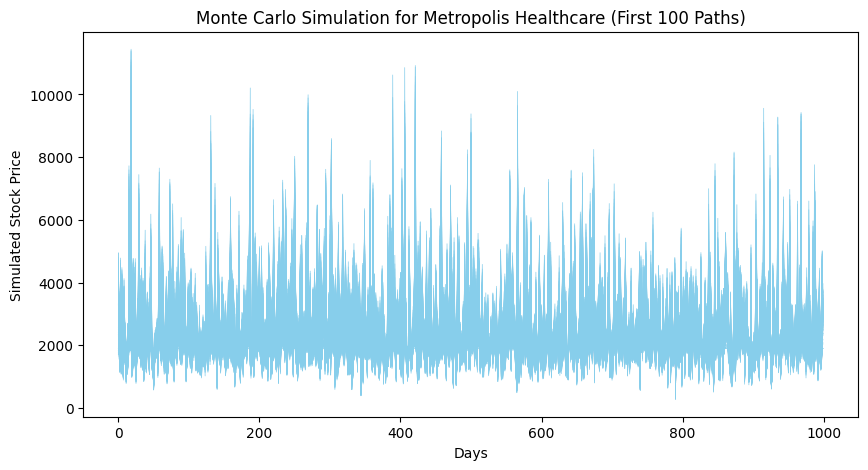

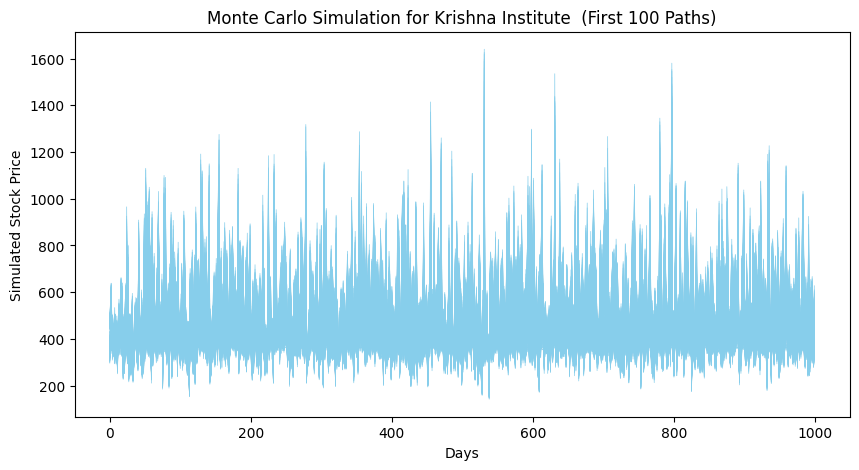

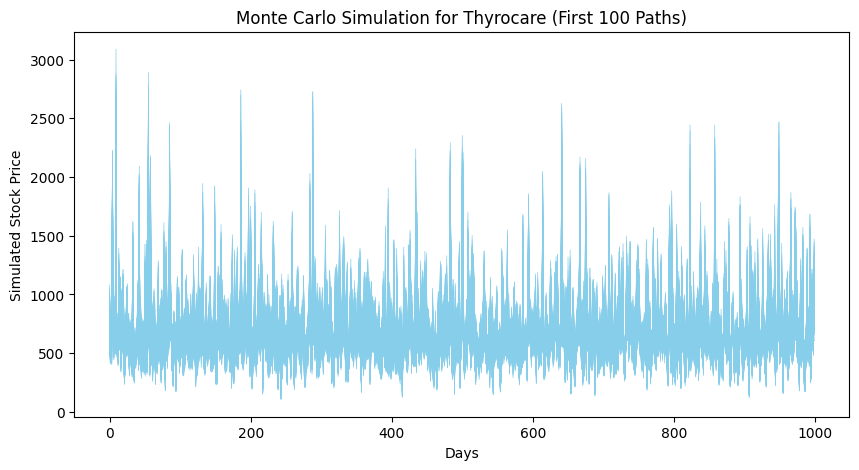

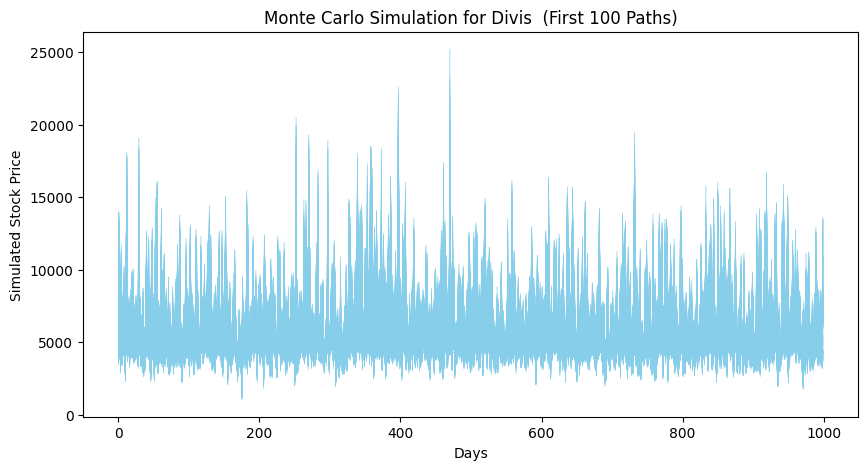

In [8]:
# Monte Carlo Simulation for Stock Prices
def monte_carlo_simulation(start_price, mu, sigma, days=252, simulations=1000):
    results = []
    for _ in range(simulations):
        prices = [start_price]
        for _ in range(days):
            prices.append(prices[-1] * (1 + np.random.normal(mu / days, sigma / np.sqrt(days))))
        results.append(prices)
    return np.array(results)

for stock in stock_data:
    start_price = stock_data[stock]['Close'].iloc[-1]
    mu = stock_data[stock]['Close'].pct_change().mean() * 252
    sigma = stock_data[stock]['Close'].pct_change().std() * np.sqrt(252)

    simulation = monte_carlo_simulation(start_price, mu, sigma)

    plt.figure(figsize=(10, 5))
    plt.plot(simulation[:, :100], lw=0.5, color='skyblue')
    plt.title(f'Monte Carlo Simulation for {stock} (First 100 Paths)')
    plt.xlabel('Days')
    plt.ylabel('Simulated Stock Price')
    plt.show()


We calculate and visualize the Value at Risk (VaR) and Conditional Value at Risk (CVaR) for daily returns which help to assess the potential losses for each stock at 95% confidence level.
VaR is representing the maximum expected loss over a time horizon (daily in this scenario) with 95% confidence level. The 5th percentile of daily returns captures this threshold.
CVaR is providing the risk by averaging the worst 5% of returns showing the expected loss severity if losses exceed the VaR level.
We then plot a histogram of daily returns with a kernel density estimate (KDE) for smoothness. The VaR and CVaR thresholds are marked on the plot with vertical lines.

Value at Risk (95% confidence): -0.058817759759367094
Conditional Value at Risk (95% confidence): -0.09247002264408528


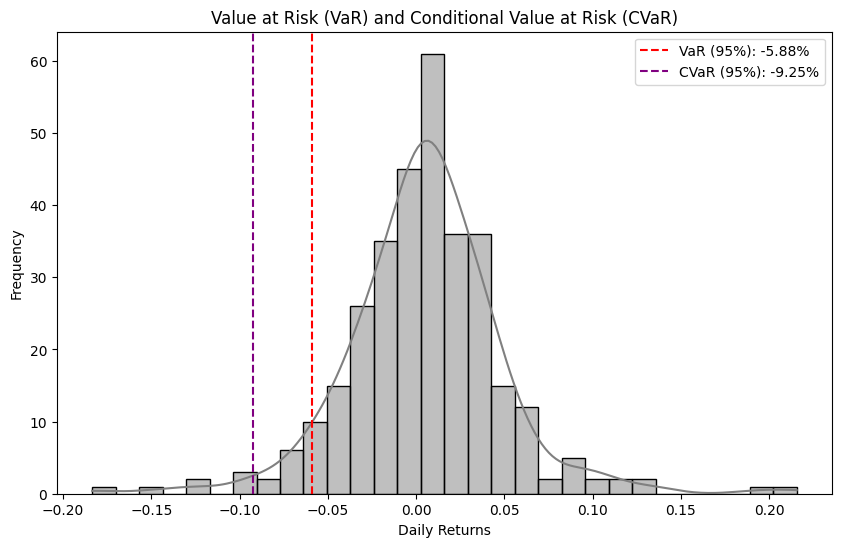

In [9]:
import seaborn as sns

# Calculated daily returns for VaR
daily_returns = stock_data[stock]['Close'].pct_change().dropna()
var_95 = np.percentile(daily_returns, 5)  # 5% quantile for 95% VaR
cvar_95 = daily_returns[daily_returns <= var_95].mean()  # Average of worst 5%

print(f"Value at Risk (95% confidence): {var_95}")
print(f"Conditional Value at Risk (95% confidence): {cvar_95}")

def plot_var_cvar(returns, var, cvar):
    plt.figure(figsize=(10, 6))
    sns.histplot(returns, kde=True, color='grey', bins=30)
    plt.axvline(var, color='red', linestyle='--', label=f'VaR (95%): {var:.2%}')
    plt.axvline(cvar, color='purple', linestyle='--', label=f'CVaR (95%): {cvar:.2%}')
    plt.title('Value at Risk (VaR) and Conditional Value at Risk (CVaR)')
    plt.xlabel('Daily Returns')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

plot_var_cvar(daily_returns, var_95, cvar_95)


Here we generate a comparative line plot showing the closing prices of all stocks over time. Each line represents the historical price movement of a different stock showing a side-by-side comparison of their performances. By including all stocks on a single graph we can view the differences in growth trends, volatility, and reactions to market events across the stocks. The labeled axes indicate the time period and stock price scale giving a view of how each stock performed individually and relative to others over time. This comparison is useful for identifying both sector-wide trends and unique performance patterns.

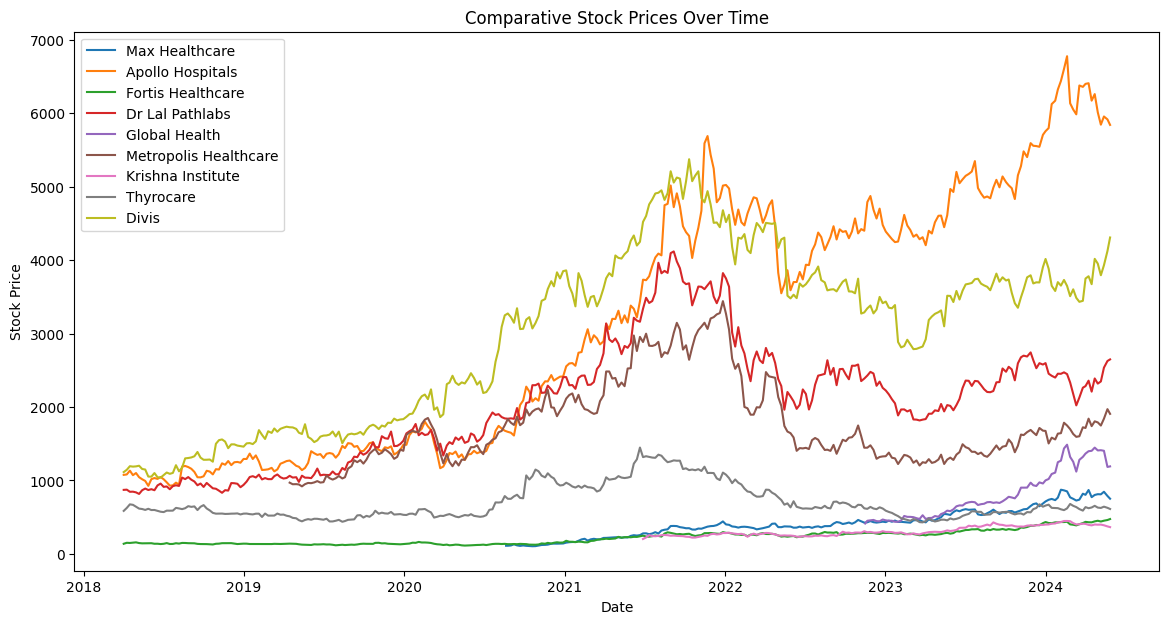

In [10]:
plt.figure(figsize=(14, 7))
for stock, data in stock_data.items():
    plt.plot(data.index, data['Close'], label=stock)
plt.title('Comparative Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

Here we generate a plot of cumulative returns for each stock, providing a direct comparison of their total growth over time from a common starting point. Cumulative returns are calculated by compounding daily percentage changes in closing prices, showing how initial investment in each stock would have grown over the period. By plotting these cumulative returns together this highlights the relative performance, helping to identify which stocks have shown the most substantial growth and which have lagged.

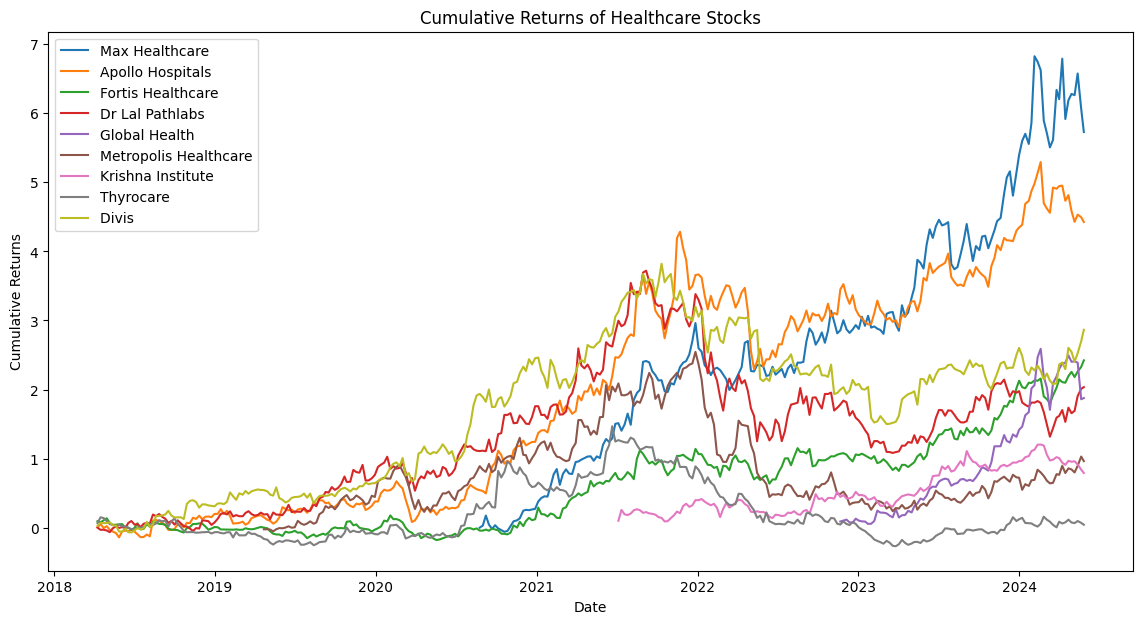

In [11]:
plt.figure(figsize=(14, 7))
for stock, data in stock_data.items():
    cumulative_returns = (1 + data['Close'].pct_change()).cumprod() - 1
    plt.plot(cumulative_returns, label=stock)
plt.title('Cumulative Returns of Healthcare Stocks')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

Here we calculate the 50-day and 200-day moving averages (MA) for each stock in the function by applying a rolling window to the closing prices. We then generated a plot for each stock, displaying the closing price along with the 50-day and 200-day moving averages. This visualization helps us see both short-term and long-term price trends, making it easier to identify potential support and resistance levels.

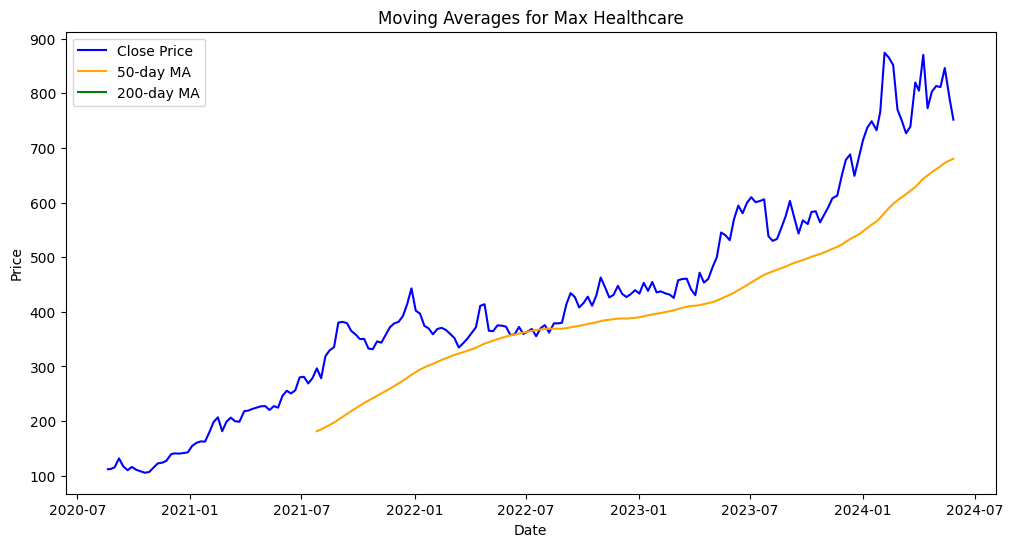

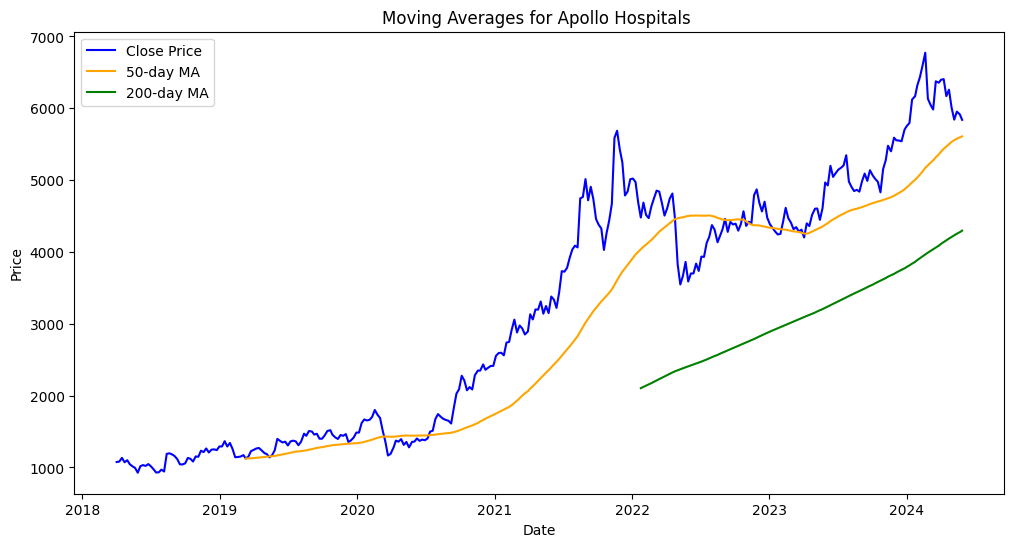

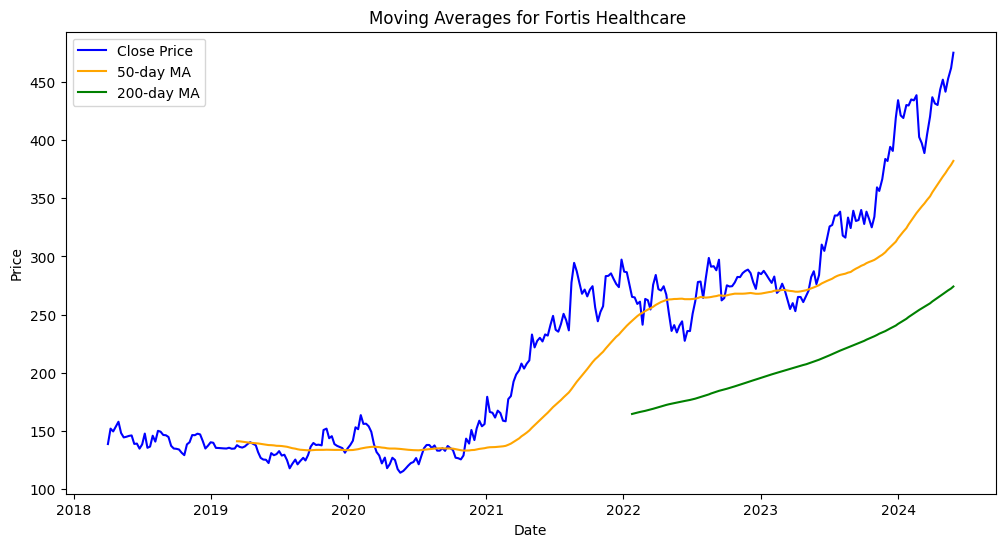

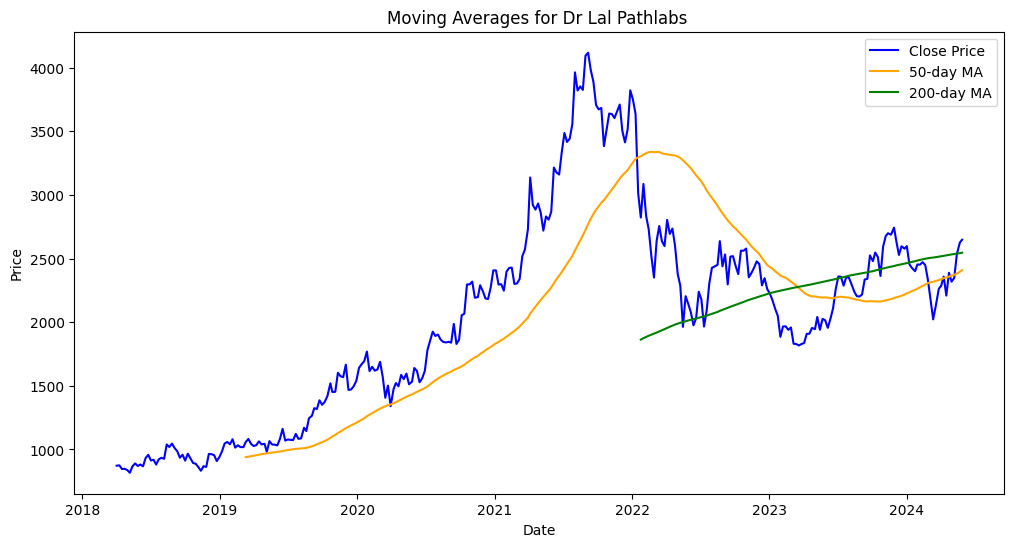

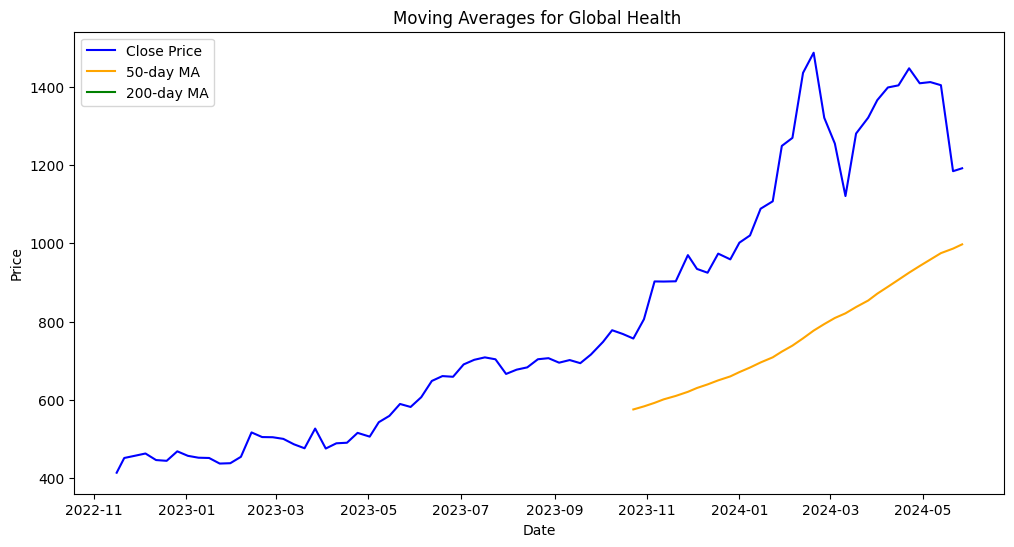

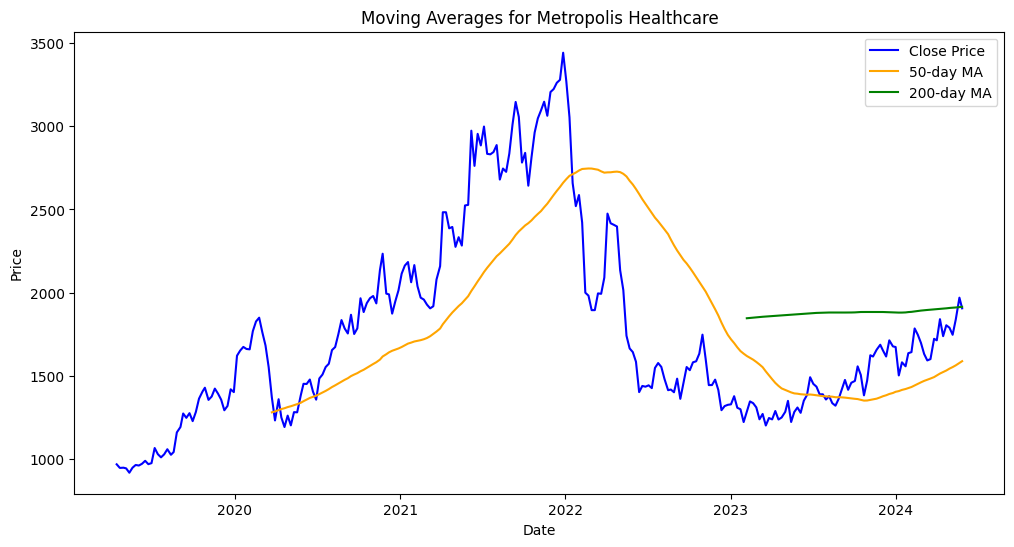

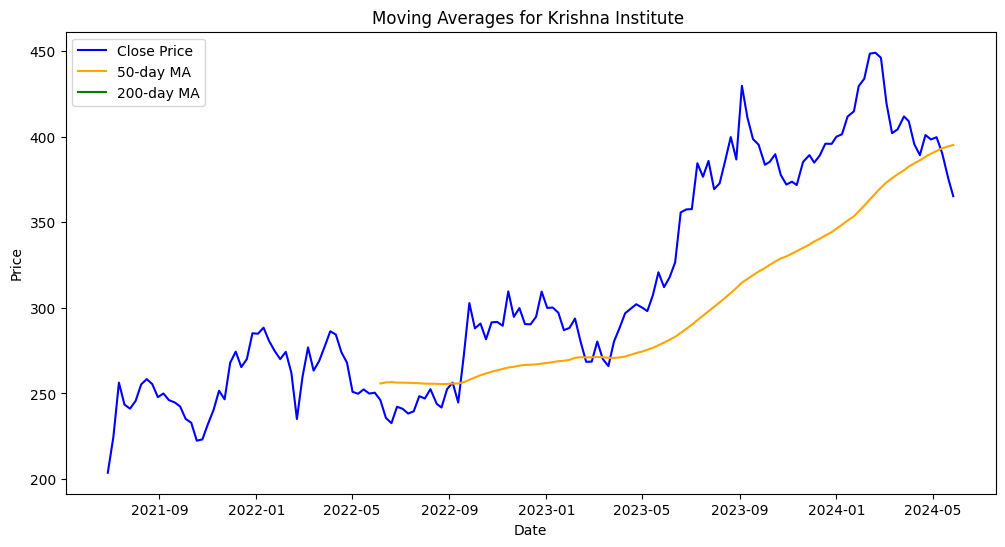

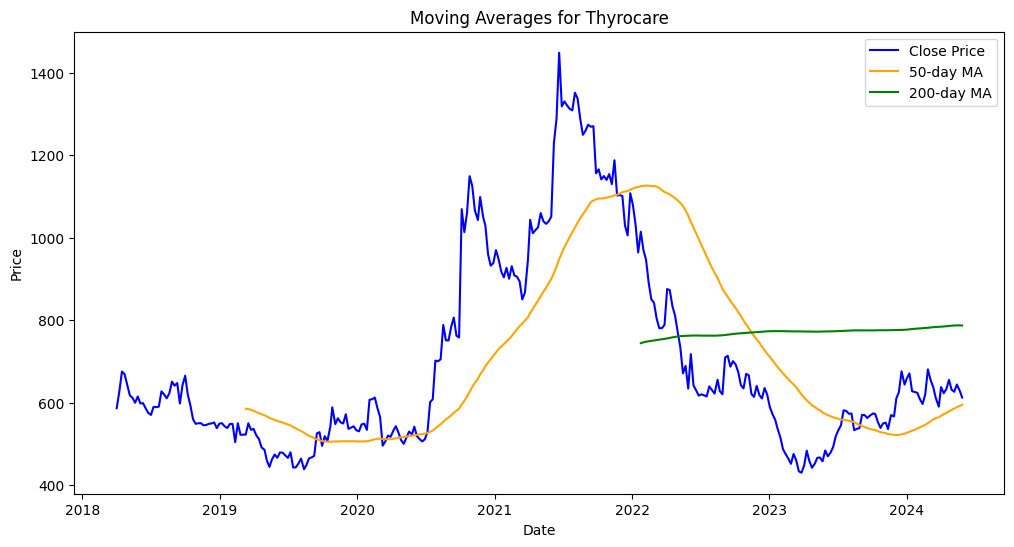

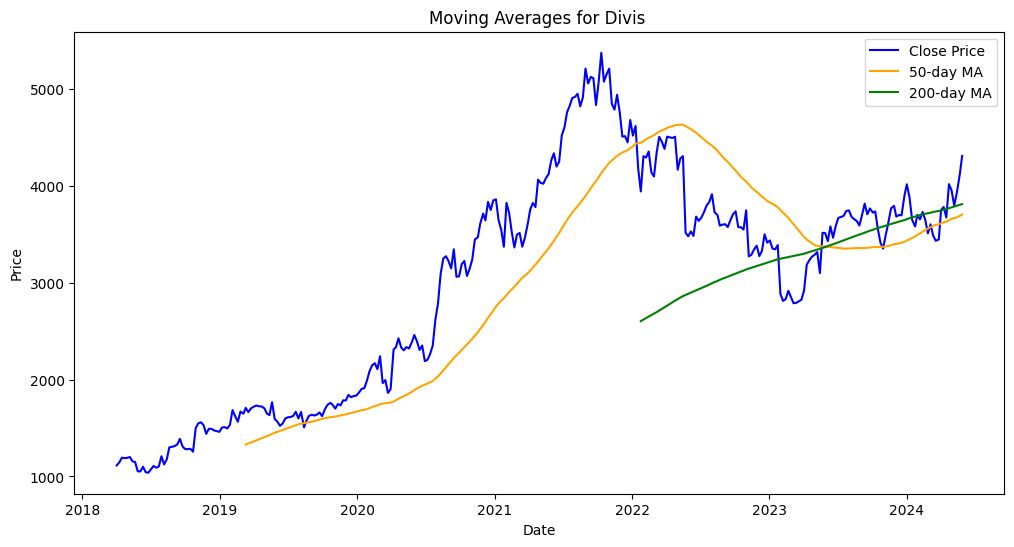

In [12]:
for stock, data in stock_data.items():
    data['50_day_MA'] = data['Close'].rolling(window=50).mean()
    data['200_day_MA'] = data['Close'].rolling(window=200).mean()

    # Plot with moving averages
    plt.figure(figsize=(12, 6))
    plt.plot(data['Close'], label='Close Price', color='blue')
    plt.plot(data['50_day_MA'], label='50-day MA', color='orange')
    plt.plot(data['200_day_MA'], label='200-day MA', color='green')
    plt.title(f'Moving Averages for {stock}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


We calculated the 30-day rolling volatility for each stock by measuring the standard deviation of the daily percentage changes in the closing prices and annualizing it. The rolling volatility for each stock is plot, providing a visual representation of volatility change over time. This helps us assess the stock's risk profile and spot periods of higher or lower market fluctuations.

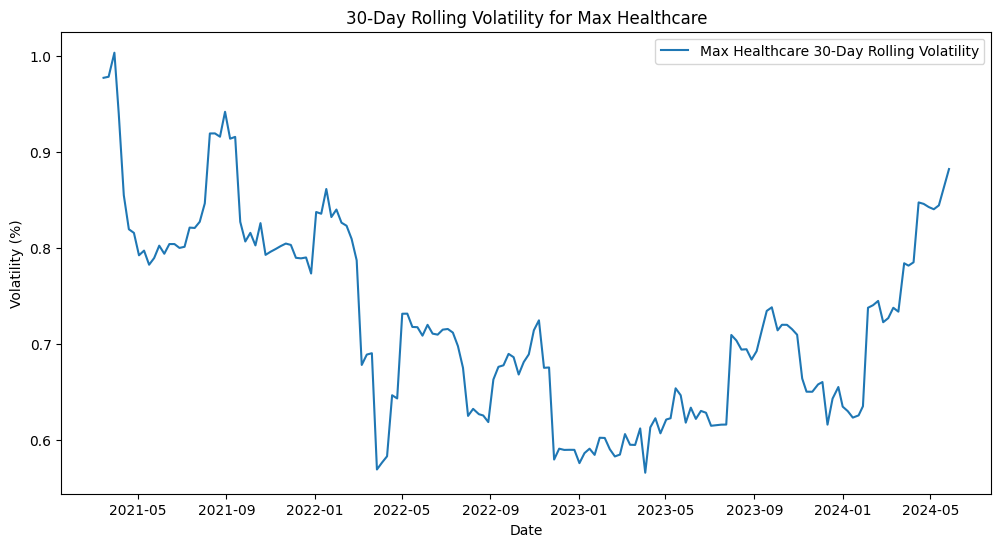

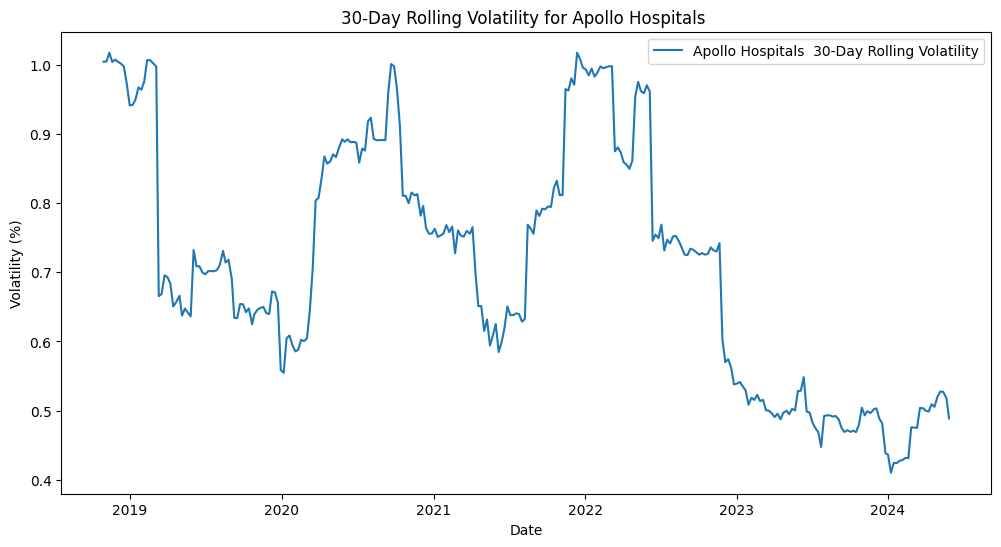

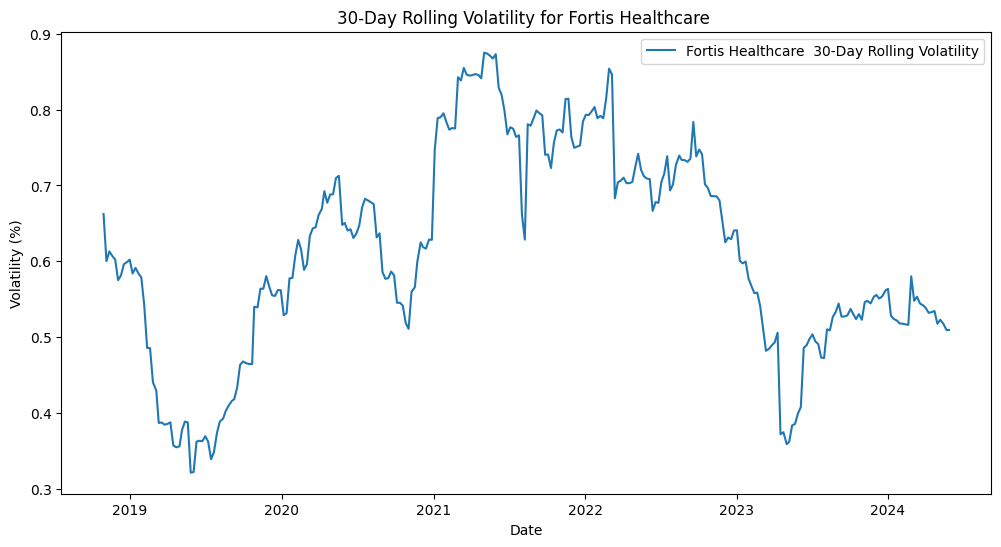

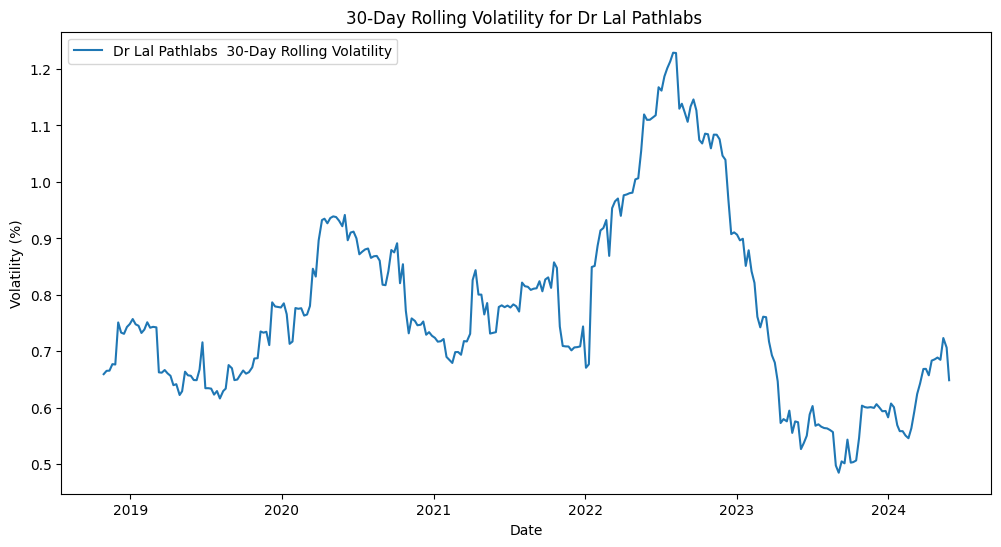

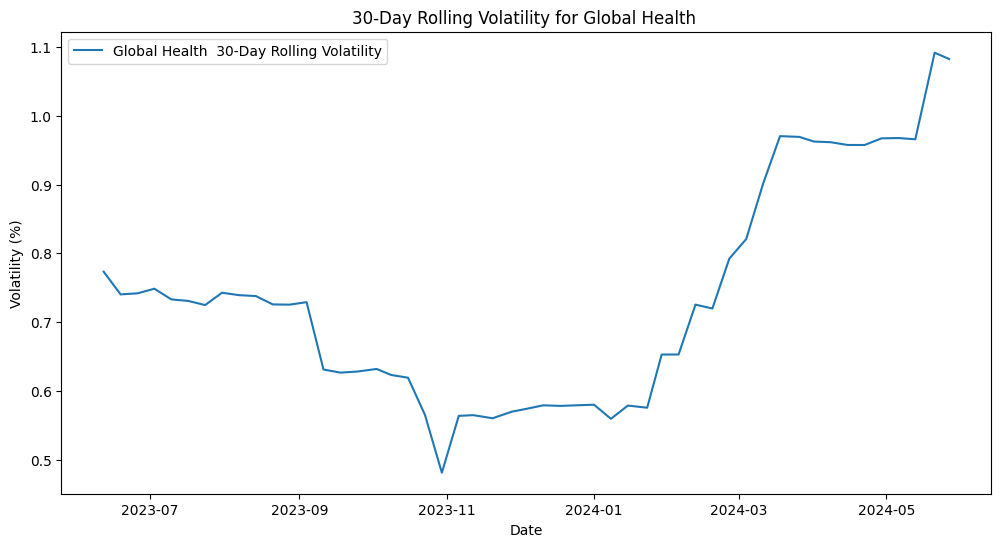

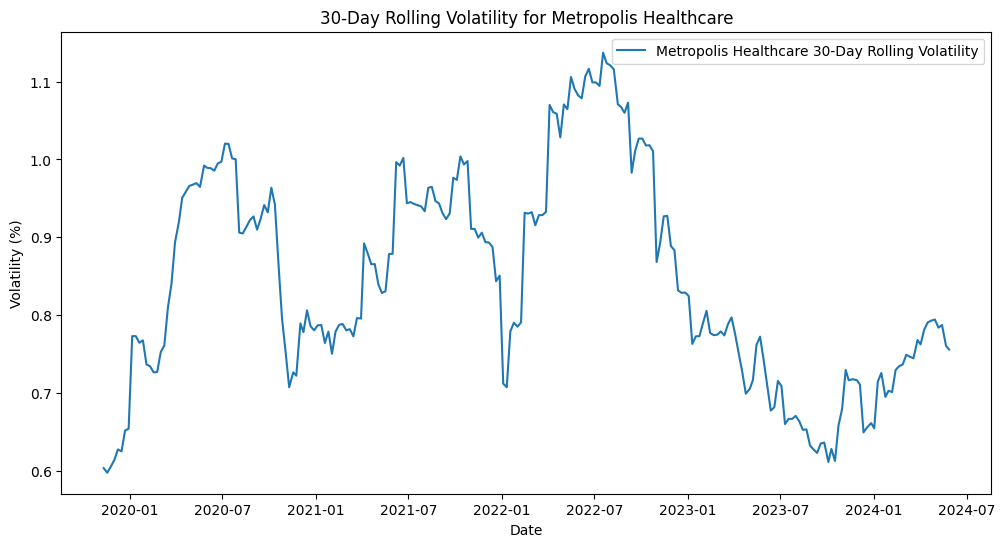

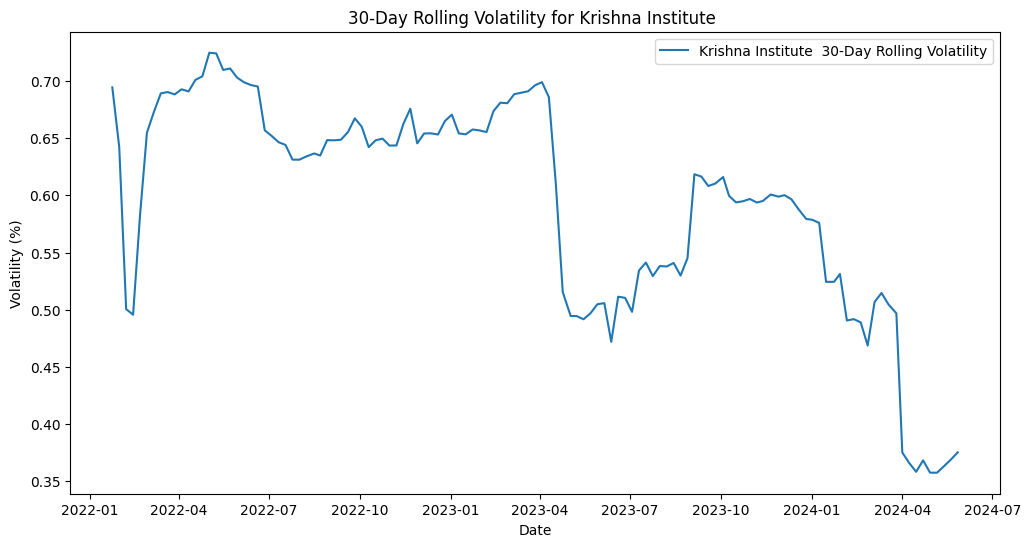

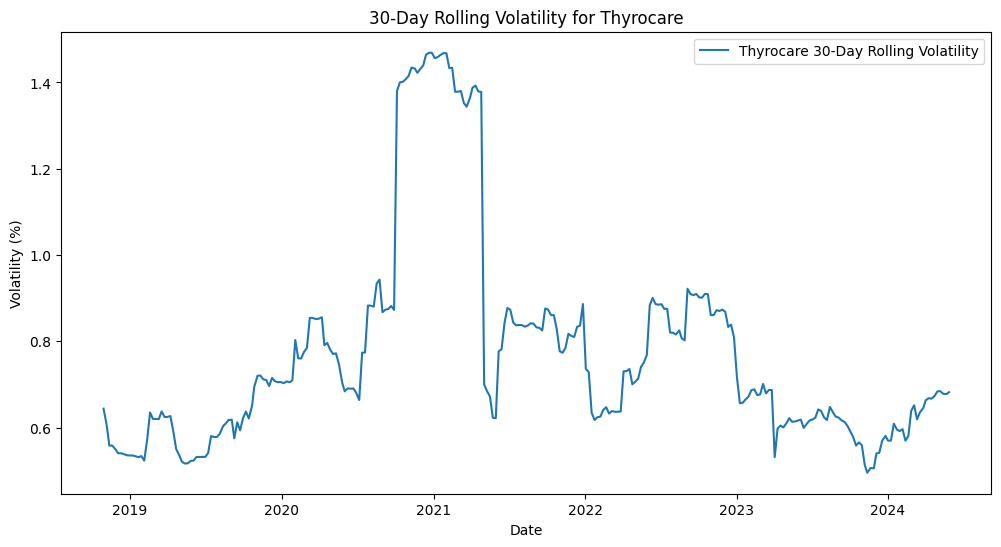

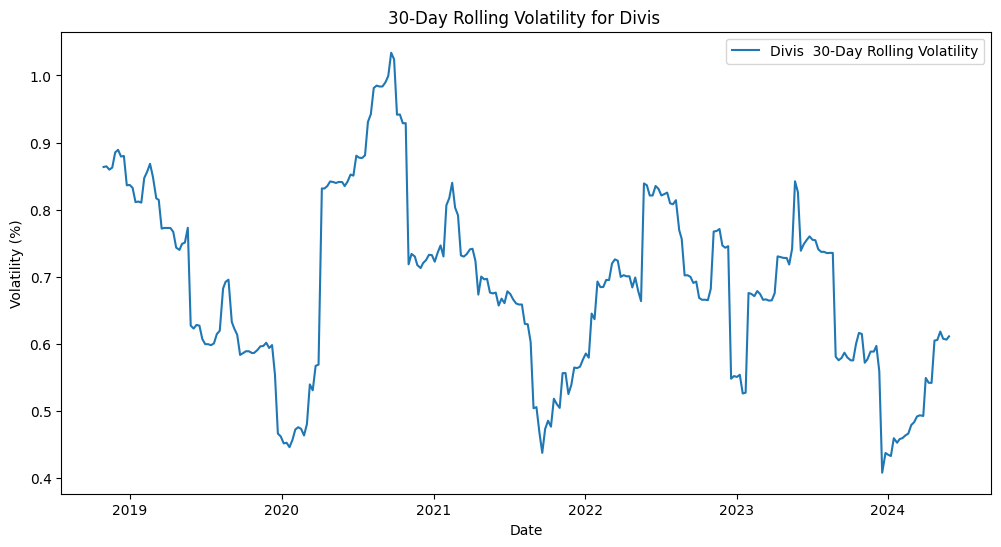

In [13]:
for stock, data in stock_data.items():
    data['Rolling Volatility'] = data['Close'].pct_change().rolling(window=30).std() * np.sqrt(252)

    plt.figure(figsize=(12, 6))
    plt.plot(data['Rolling Volatility'], label=f'{stock} 30-Day Rolling Volatility')
    plt.title(f'30-Day Rolling Volatility for {stock}')
    plt.xlabel('Date')
    plt.ylabel('Volatility (%)')
    plt.legend()
    plt.show()


This code plots the cumulative returns for each stock allowing comparison of their total growth over time. It also highlights two key events—India's lockdown start on March 24, 2020, and the vaccine rollout on March 11, 2021 by marking them with vertical lines. The plot helps visualize how these events might have impacted stock performance and tracks the cumulative return relative to these milestones.

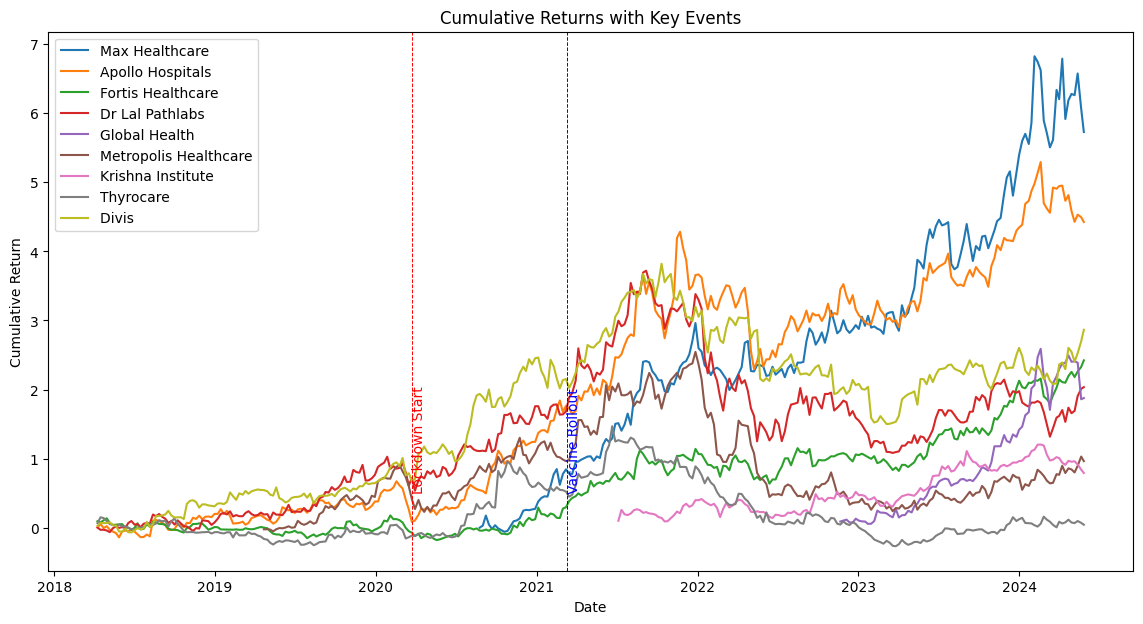

In [14]:
plt.figure(figsize=(14, 7))
for stock, data in stock_data.items():
    cumulative_returns = (1 + data['Close'].pct_change()).cumprod() - 1
    plt.plot(cumulative_returns, label=stock)

# Showed the major events
plt.axvline(pd.to_datetime('2020-03-24'), color='red', linestyle='--', linewidth=0.7)  # India lockdown start
plt.axvline(pd.to_datetime('2021-03-11'), color='blue', linestyle='--', linewidth=0.7)  # Vaccine rollout
plt.text(pd.to_datetime('2020-03-24'), 0.5, 'Lockdown Start', rotation=90, verticalalignment='bottom', color='red')
plt.text(pd.to_datetime('2021-03-11'), 0.5, 'Vaccine Rollout', rotation=90, verticalalignment='bottom', color='blue')

plt.title('Cumulative Returns with Key Events')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()


This code calculates and displays the annualized return, annualized volatility, and Sharpe ratio for each stock. The annual return is computed by multiplying the daily return by 252 (the typical number of trading days in a year), while the annual volatility is the standard deviation of the daily returns, also scaled by the square root of 252. The Sharpe ratio is calculated assuming a 4% risk-free rate, measuring the risk-adjusted return.

In [15]:
results = []
for stock, data in stock_data.items():
    daily_returns = data['Close'].pct_change().dropna()
    annual_return = daily_returns.mean() * 252
    annual_volatility = daily_returns.std() * np.sqrt(252)
    sharpe_ratio = (annual_return - 0.04) / annual_volatility  # assuming risk-free rate of 4%
    results.append({
        'Stock': stock,
        'Annualized Return (%)': annual_return * 100,
        'Annualized Volatility (%)': annual_volatility * 100,
        'Sharpe Ratio': sharpe_ratio
    })

results_df = pd.DataFrame(results)
print(results_df)


                   Stock  Annualized Return (%)  Annualized Volatility (%)  \
0         Max Healthcare             274.091122                  76.836321   
1      Apollo Hospitals              159.181093                  73.136779   
2     Fortis Healthcare              115.742807                  62.197190   
3       Dr Lal Pathlabs              117.518186                  77.938730   
4         Global Health              369.383660                  83.464650   
5  Metropolis Healthcare              98.743647                  83.766116   
6     Krishna Institute              114.985971                  60.799995   
7              Thyrocare              33.382863                  79.941781   
8                 Divis              130.246266                  69.407163   

   Sharpe Ratio  
0      3.515149  
1      2.121793  
2      1.796589  
3      1.456505  
4      4.377706  
5      1.131050  
6      1.825427  
7      0.367553  
8      1.818923  


This code calculates the average annualized return, average annualized volatility, and average Sharpe ratio for all the stocks. It computes these averages by taking the mean of the respective columns. Then the sector-wide averages is providing a summary of overall performance and risk-adjusted returns across all the stocks being analyzed. The results help in understanding the general trends and risks within the stock sector.

In [16]:
# Average metrics
average_annual_return = results_df['Annualized Return (%)'].mean()
average_annual_volatility = results_df['Annualized Volatility (%)'].mean()
average_sharpe_ratio = results_df['Sharpe Ratio'].mean()

print("Sector-Wide Averages:")
print(f"Average Annualized Return: {average_annual_return:.2f}%")
print(f"Average Annualized Volatility: {average_annual_volatility:.2f}%")
print(f"Average Sharpe Ratio: {average_sharpe_ratio:.2f}")


Sector-Wide Averages:
Average Annualized Return: 157.03%
Average Annualized Volatility: 74.17%
Average Sharpe Ratio: 2.05


Here we code to create a correlation matrix of the closing prices for multiple stocks. It first concatenates the closing prices of all stocks then calculates the correlation between them. The resulting correlation matrix is visualized using a heatmap, with color coding indicating the strength and direction of the correlations (ranging from -1 to 1). This analysis helps to understand how the stocks move in relation to one another, providing insights into diversification opportunities or potential risk factors when selecting stocks for a portfolio.

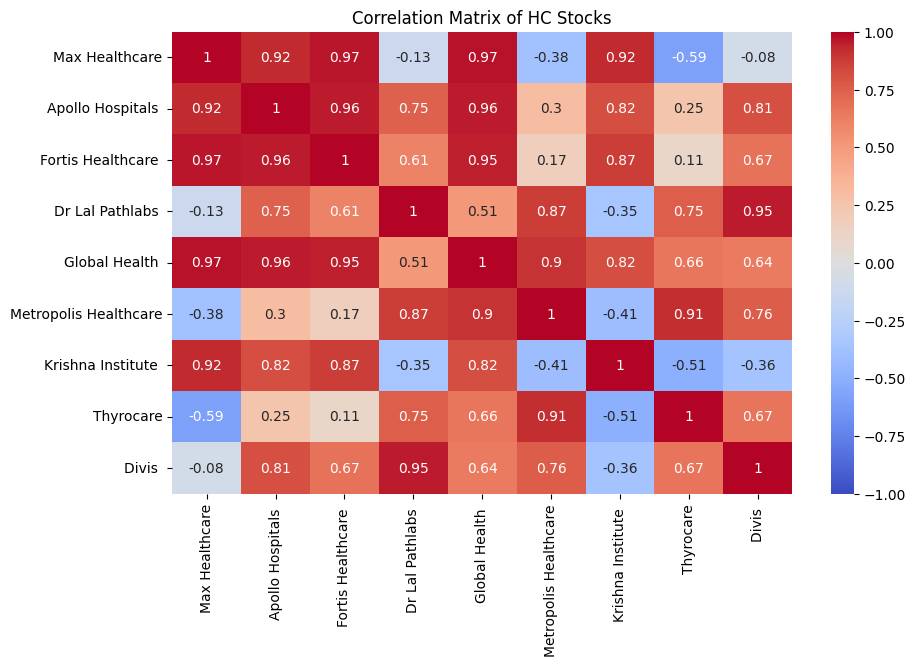

In [17]:
# Closing prices into a single DataFrame for correlation analysis
closing_prices = pd.concat([data['Close'] for data in stock_data.values()], axis=1)
closing_prices.columns = list(stock_data.keys())

plt.figure(figsize=(10, 6))
sns.heatmap(closing_prices.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of HC Stocks')
plt.show()


This code generates macrodata with monthly data from March 2018 to March 2024 for four economic variables: Supply Chain Index, Interest Rate, Inflation, and Exchange Rate. The data is simulated using random noise and trends, providing a basis for analysis or integration with stock data.

In [25]:
import numpy as np
import pandas as pd

dates = pd.date_range(start="2018-03-01", end="2024-03-01", freq="M")
np.random.seed(0)

# Supply Chain Index (normalized to start around 100 with variability)
supply_chain_index = np.random.normal(100, 5, len(dates))

# Interest Rates (RBI repo rates in %)
interest_rate = np.linspace(5.5, 4.0, len(dates)) + np.random.normal(0, 0.1, len(dates))

# Inflation (CPI % change YoY)
inflation = np.linspace(2, 6, len(dates)) + np.random.normal(0, 0.5, len(dates))

# Exchange Rate (USD to INR)
exchange_rate = np.linspace(65, 80, len(dates)) + np.random.normal(0, 1, len(dates))

# Consumer Demand Index (normalized to start around 100 with variability)
consumer_demand_index = np.random.normal(100, 5, len(dates))

macro_data = pd.DataFrame({
    'Date': dates,
    'Supply_Chain_Index': supply_chain_index,
    'Interest_Rate': interest_rate,
    'Inflation': inflation,
    'Exchange_Rate': exchange_rate,
    'Consumer_Demand_Index' : consumer_demand_index
})

macro_data.head()


<ipython-input-25-e8dcc5fe3516>:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start="2018-03-01", end="2024-03-01", freq="M")


Date  Supply_Chain_Index  Interest_Rate  Inflation  Exchange_Rate  \
0 2018-03-31          108.820262       5.613940   3.191572      64.982980   
1 2018-04-30          102.000786       5.355391   2.528578      65.590419   
2 2018-05-31          104.893690       5.497981   1.656265      67.681844   
3 2018-06-30          111.204466       5.368139   2.727522      65.591546   
4 2018-07-31          109.337790       5.328413   1.567398      64.889125   

   Consumer_Demand_Index  
0             103.449091  
1             106.509231  
2              96.859562  
3              97.594864  
4             111.519583

This code calculates the monthly returns for each stock by computing the percentage change in the closing price. It then merges this returns data with the macroeconomic data (such as Supply Chain Index, Interest Rate, Inflation, and Exchange Rate) based on the Date column.

In [26]:
# Monthly returns for each stock and merging with macroeconomic data
combined_data = {}
for stock, data in stock_data.items():
    data['Returns'] = data['Close'].pct_change()
    combined_data[stock] = pd.merge(data[['Returns']], macro_data, on='Date', how='inner')

combined_data[list(combined_data.keys())[0]].head()


Date   Returns  Supply_Chain_Index  Interest_Rate  Inflation  \
0 2020-08-31  0.029477          107.346794       4.752548   3.308290   
1 2021-05-31  0.094856           98.063366       4.883939   3.819036   
2 2022-01-31 -0.029225           93.736023       4.589577   3.945121   
3 2022-02-28 -0.019899          103.887452       4.599263   4.781413   
4 2022-10-31  0.075520          102.141659       4.522955   5.766856   

   Exchange_Rate  Consumer_Demand_Index  
0      69.450757              98.565564  
1      73.719708              99.211665  
2      74.121996              86.704139  
3      74.877010             103.031598  
4      73.847126              93.929613

Here we code to run multiple regression models for each stock in the dataset. It uses macroeconomic variables (Supply Chain Index, Interest Rate, Inflation, Exchange Rate) as independent variables to explain the stock's monthly returns (dependent variable). The code checks if there is enough data for regression, handles missing values, adds a constant term for the intercept, and runs Ordinary Least Squares (OLS) regression. It then prints the regression summary for each stock, showing the relationships between the returns and the macroeconomic factors.

In [27]:
import statsmodels.api as sm

# Regression models
for stock, data in combined_data.items():
    X = data[['Supply_Chain_Index', 'Interest_Rate', 'Inflation', 'Exchange_Rate', 'Consumer_Demand_Index']]
    y = data['Returns']

    combined_data[stock] = combined_data[stock].dropna()

    X = combined_data[stock][['Supply_Chain_Index', 'Interest_Rate', 'Inflation', 'Exchange_Rate','Consumer_Demand_Index']]
    y = combined_data[stock]['Returns']
    X = sm.add_constant(X)  # Adding a constant term to the regression

    # Checking if enough data for regression
    if len(X) < 2 or len(y) < 2:
        continue

    # Checking for NaN values in the dependent variable
    if y.isnull().any():
        y = y.dropna()
        X = X.loc[y.index]

    # Running regression only if there are enough observations
    if len(y) > 0 and len(X) > 0:
        model = sm.OLS(y, X).fit()

        print(f"Regression results for {stock}:")
        print(model.summary())
    else:
        continue

Regression results for Max Healthcare:
                            OLS Regression Results                            
Dep. Variable:                Returns   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 15 Nov 2024   Prob (F-statistic):                nan
Time:                        18:07:00   Log-Likelihood:                 191.87
No. Observations:                   6   AIC:                            -371.7
Df Residuals:                       0   BIC:                            -373.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, 

Here we model the volatility while factoring in the macroeconomic influences particulary considering the supply chain index due to its adverse impact, offering insights into how the changes might affect each stock's volatility. The plot of the conditional volatility over time is generated for each stock, showing how risk levels fluctuate with changes. Peaks in the plot indicate periods of heightened volatility, driven by shifts in the included economic factor. This approach provides a dynamic view of volatility that is sensitive to the macroeconomic environment.

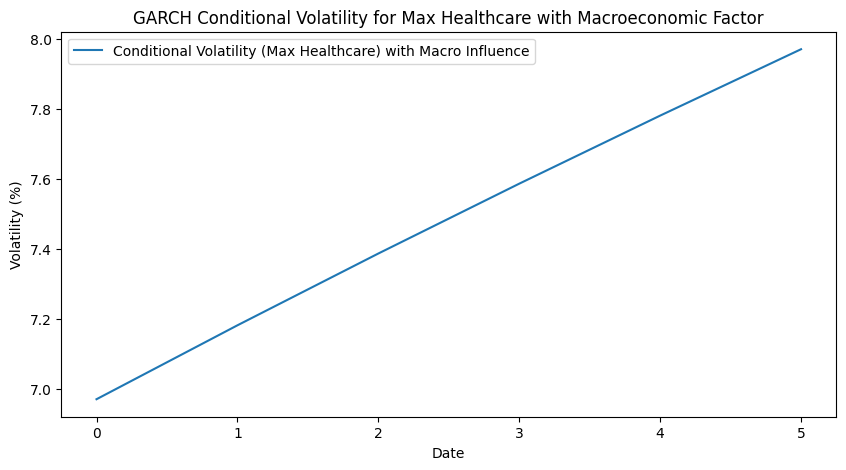

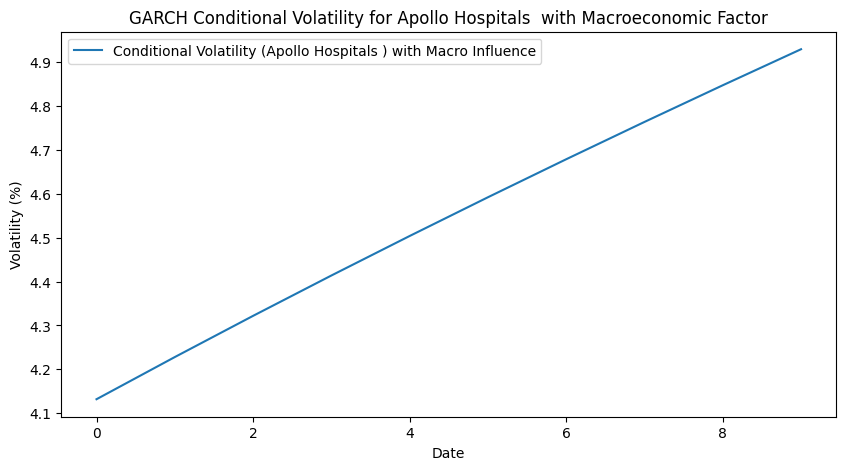

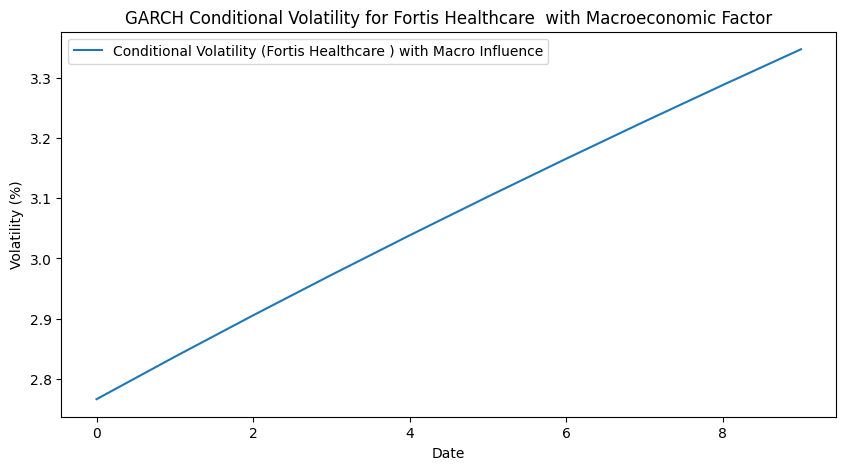

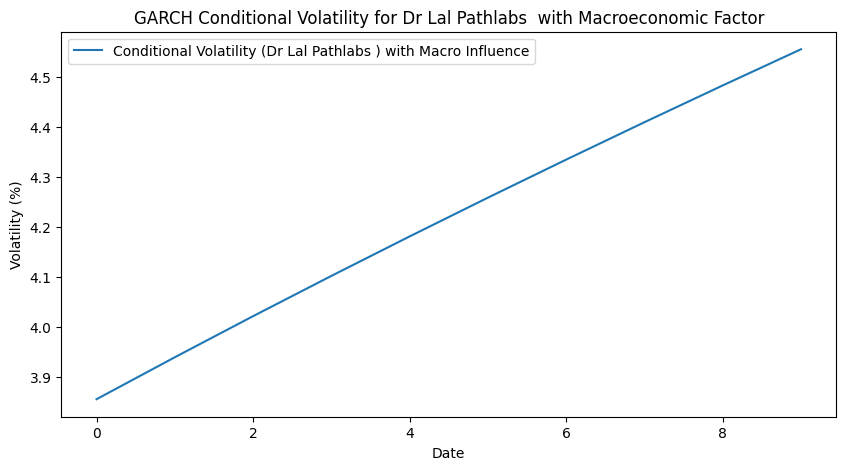

/usr/local/lib/python3.10/dist-packages/arch/univariate/volatility.py:1215: RuntimeWarning: invalid value encountered in scalar divide
  scale = np.mean(resids**2) / (target ** (2.0 / power))
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:449: RuntimeWarning: divide by zero encountered in log
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:449: RuntimeWarning: invalid value encountered in divide
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:449: RuntimeWarning: divide by zero encountered in divide
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
/usr/local/lib/python3.10/dist-packages/arch/univariate/distribution.py:449: RuntimeWarning: invalid value encountered in add
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
/usr/local/lib/python3.1

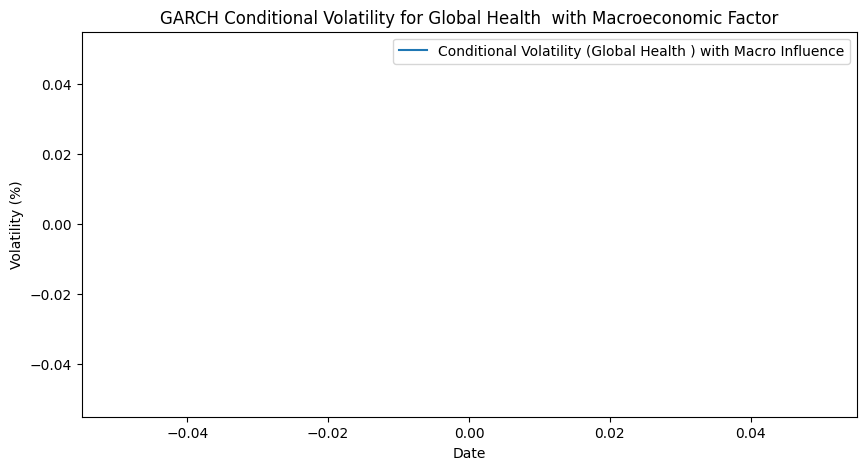

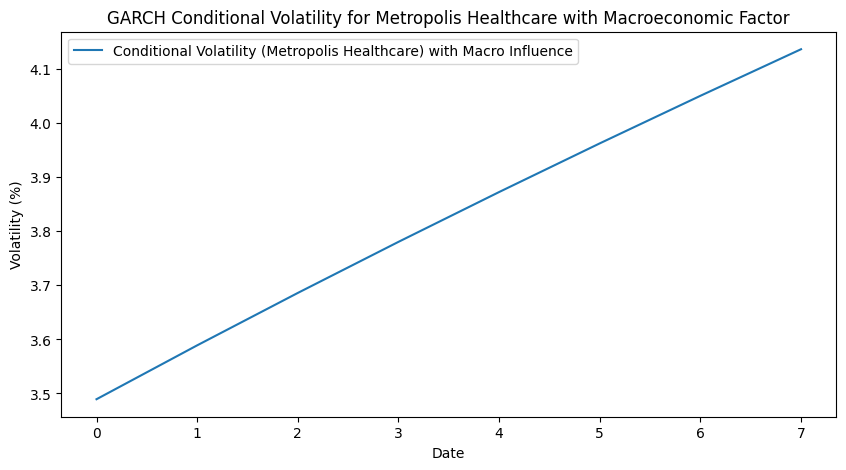

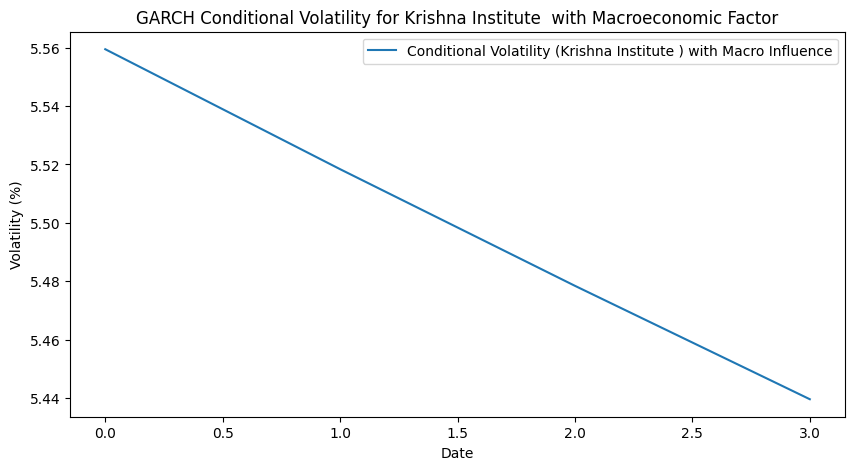

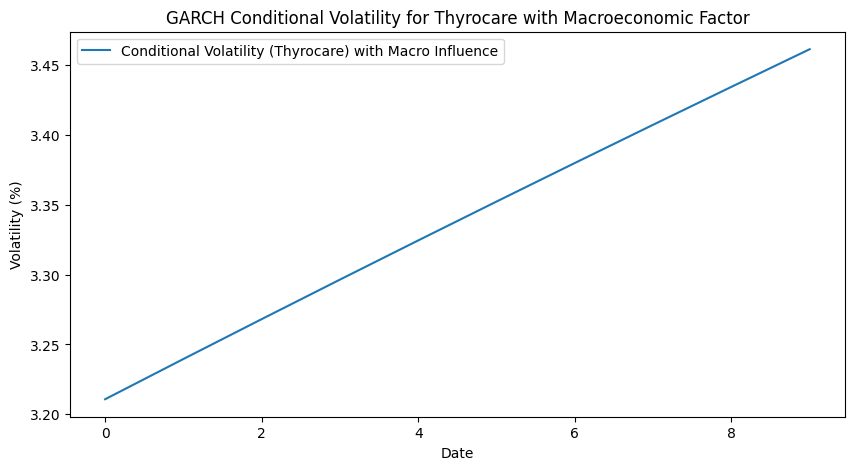

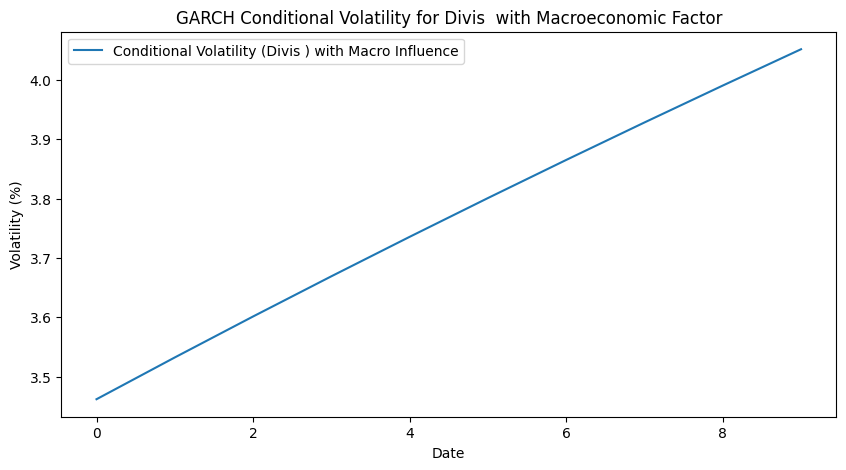

In [28]:
from arch import arch_model

# GARCH model with macroeconomic factor as external regressors
for stock, data in combined_data.items():
    returns = data['Returns'].dropna() * 100
    exog = data[['Supply_Chain_Index']].dropna() #Factor can be changed as per consideration to 'Interest_Rate', 'Inflation', 'Exchange_Rate'

    # GARCH model with external regressors
    garch_model = arch_model(returns, vol='Garch', p=1, q=1, x=exog)
    garch_result = garch_model.fit(disp="off")

    # GARCH model summary
    # print(f"GARCH Model Summary for {stock}:")
    # print(garch_result.summary())

    # Conditional volatility over time with macro influence
    plt.figure(figsize=(10, 5))
    plt.plot(returns.index, garch_result.conditional_volatility, label=f'Conditional Volatility ({stock}) with Macro Influence')
    plt.title(f'GARCH Conditional Volatility for {stock} with Macroeconomic Factor')
    plt.xlabel('Date')
    plt.ylabel('Volatility (%)')
    plt.legend()
    plt.show()

This code performs Monte Carlo simulation for each stock's future prices, adjusted by the macroeconomic influence, to reflect a range of possible outcomes under varying economic conditions. It starts by using a linear regression model to determine the influence of a macroeconomic factor on each stock’s returns, producing an adjusted mean return that varies based on these factors. The resulting plot displays the first 100 paths from the simulation, illustrating a spectrum of potential price trajectories that consider the impact of macroeconomic conditions on stock price movements. This simulation helps evaluate future price uncertainty and provides a probabilistic view of potential investment outcomes.

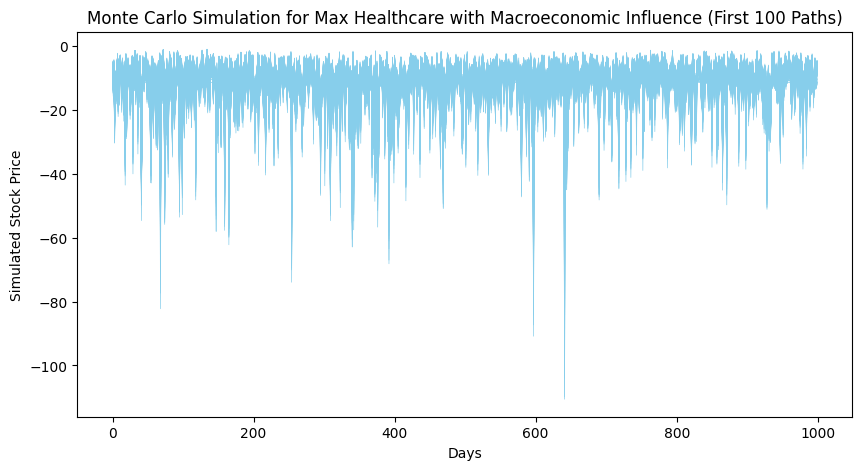

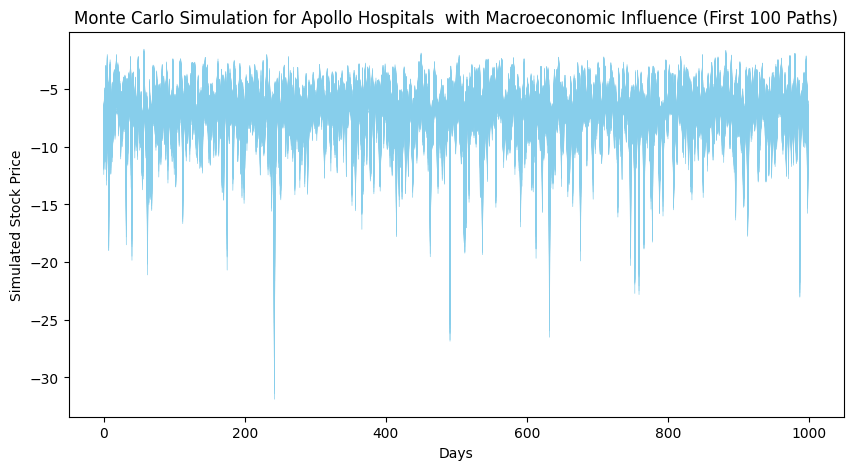

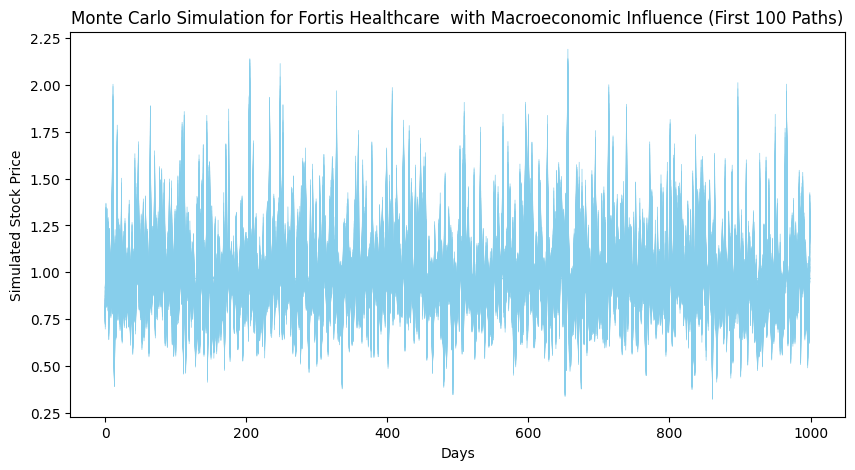

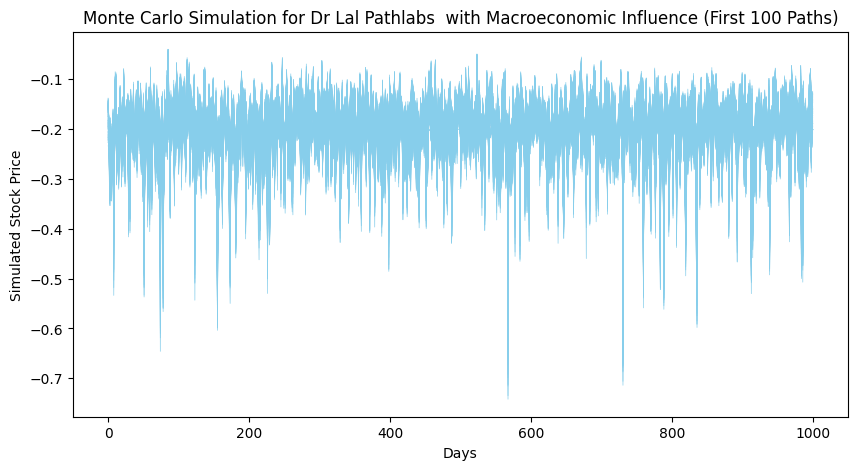

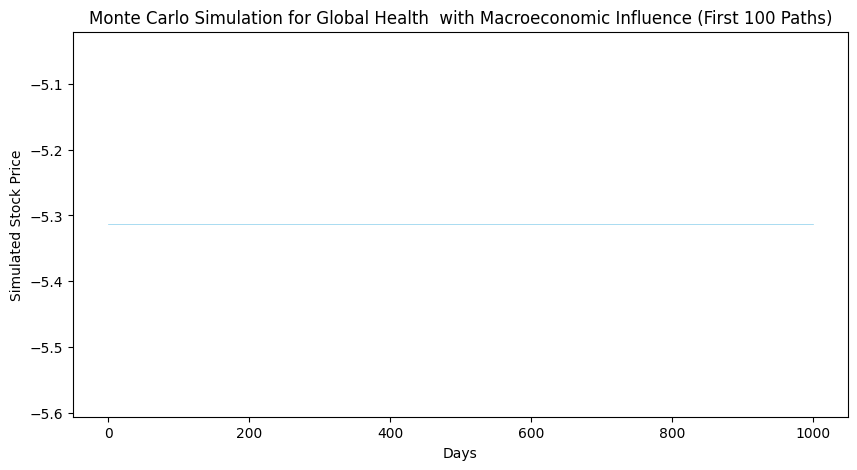

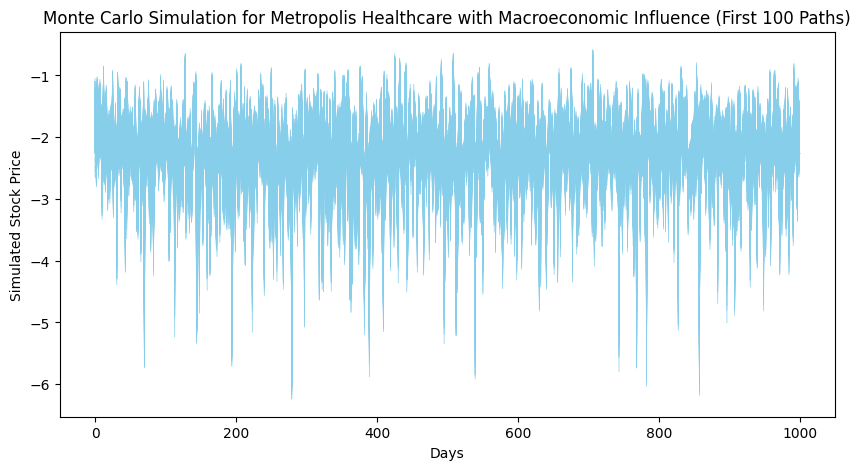

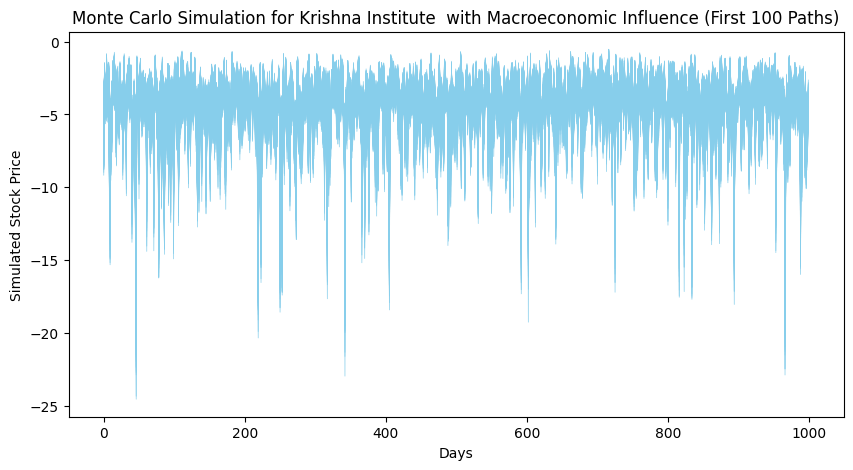

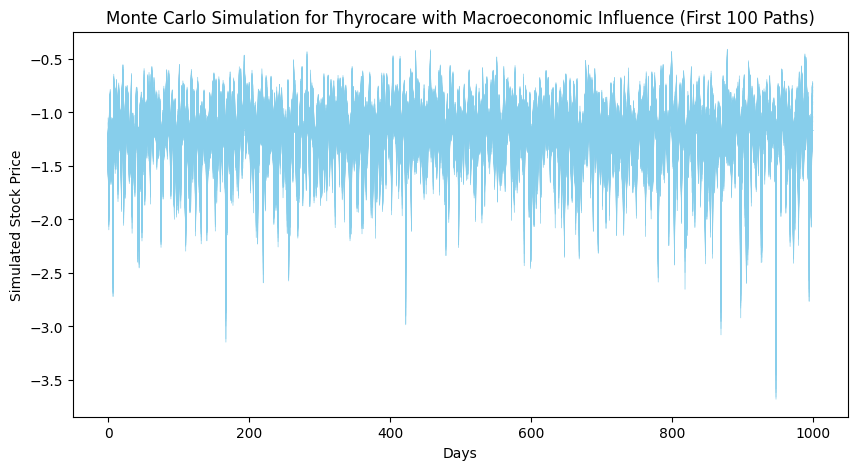

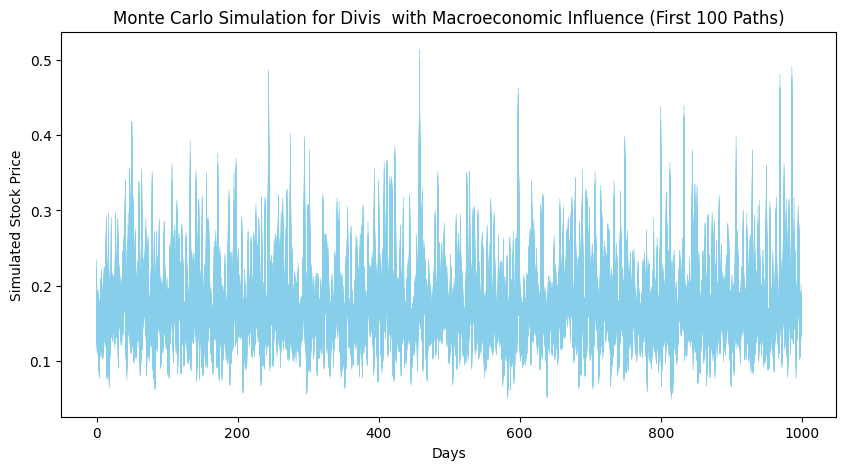

In [29]:
from sklearn.linear_model import LinearRegression

# Monte Carlo Simulation adjusted for macroeconomic factors
def monte_carlo_simulation_with_macro(start_price, adjusted_mu, sigma, days=252, simulations=1000):
    results = []
    for _ in range(simulations):
        prices = [start_price]
        for day in range(days):
            mu_day = adjusted_mu[day % len(adjusted_mu)] / days  # Adjust daily mean return
            prices.append(prices[-1] * (1 + np.random.normal(mu_day, sigma / np.sqrt(days))))
        results.append(prices)
    return np.array(results)

for stock, data in combined_data.items():
    X = data[['Supply_Chain_Index']] #Factor can be changed as per consideration to 'Interest_Rate', 'Inflation', 'Exchange_Rate'
    y = data['Returns']
    model = LinearRegression().fit(X, y)
    adjusted_mu = model.intercept_ + np.dot(macro_data[['Supply_Chain_Index']], model.coef_) #Factor can be changed as per consideration to 'Interest_Rate', 'Inflation', 'Exchange_Rate'

    start_price = data['Returns'].iloc[-1] * 100  # Adjusted starting point based on latest return
    sigma = y.std() * np.sqrt(252)

    simulation = monte_carlo_simulation_with_macro(start_price, adjusted_mu, sigma)

    plt.figure(figsize=(10, 5))
    plt.plot(simulation[:, :100], lw=0.5, color='skyblue')
    plt.title(f'Monte Carlo Simulation for {stock} with Macroeconomic Influence (First 100 Paths)')
    plt.xlabel('Days')
    plt.ylabel('Simulated Stock Price')
    plt.show()

This code checks for multicollinearity by calculating and visualizing the correlation matrix between the stock returns and key macroeconomic variables (Supply Chain Index, Interest Rate, Inflation, and Exchange Rate) for each stock. The correlation matrix is displayed for each stock, and a heatmap is plotted to visually represent the strength and direction of the relationships. High correlations between variables may indicate multicollinearity, which could affect the reliability of regression models.

Correlation matrix for Max Healthcare:
                         Returns  Supply_Chain_Index  Interest_Rate  Inflation  \
Returns                1.000000            0.089945       0.801074  -0.340748   
Supply_Chain_Index     0.089945            1.000000       0.030367   0.023698   
Interest_Rate          0.801074            0.030367       1.000000  -0.798268   
Inflation             -0.340748            0.023698      -0.798268   1.000000   
Exchange_Rate         -0.631212           -0.400820      -0.758211   0.743281   
Consumer_Demand_Index -0.347048            0.546268      -0.322384   0.327075   

                       Exchange_Rate  Consumer_Demand_Index  
Returns                    -0.631212              -0.347048  
Supply_Chain_Index         -0.400820               0.546268  
Interest_Rate              -0.758211              -0.322384  
Inflation                   0.743281               0.327075  
Exchange_Rate               1.000000               0.392211  
Consumer_Demand_Inde

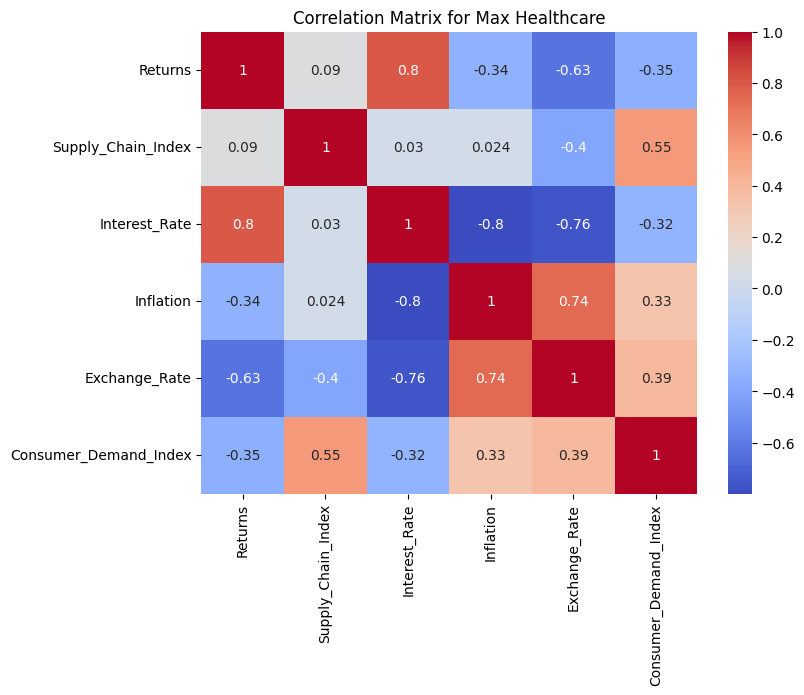

Correlation matrix for Apollo Hospitals :
                         Returns  Supply_Chain_Index  Interest_Rate  Inflation  \
Returns                1.000000           -0.352496       0.355040  -0.439351   
Supply_Chain_Index    -0.352496            1.000000       0.080044  -0.044757   
Interest_Rate          0.355040            0.080044       1.000000  -0.927914   
Inflation             -0.439351           -0.044757      -0.927914   1.000000   
Exchange_Rate         -0.229202           -0.273747      -0.925206   0.881930   
Consumer_Demand_Index -0.269916            0.420783       0.322289  -0.256197   

                       Exchange_Rate  Consumer_Demand_Index  
Returns                    -0.229202              -0.269916  
Supply_Chain_Index         -0.273747               0.420783  
Interest_Rate              -0.925206               0.322289  
Inflation                   0.881930              -0.256197  
Exchange_Rate               1.000000              -0.185029  
Consumer_Demand_I

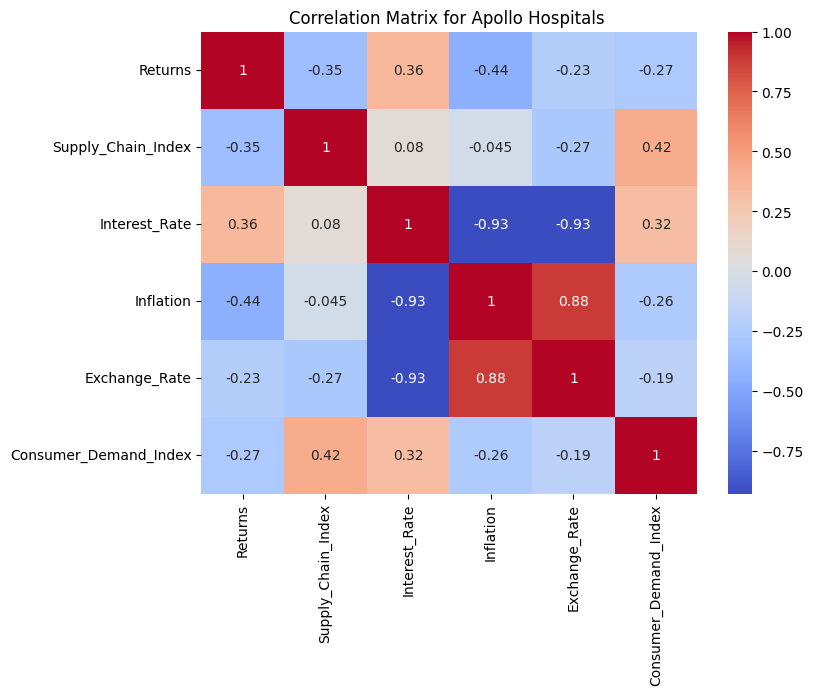

Correlation matrix for Fortis Healthcare :
                         Returns  Supply_Chain_Index  Interest_Rate  Inflation  \
Returns                1.000000            0.378818      -0.133476   0.240351   
Supply_Chain_Index     0.378818            1.000000       0.080044  -0.044757   
Interest_Rate         -0.133476            0.080044       1.000000  -0.927914   
Inflation              0.240351           -0.044757      -0.927914   1.000000   
Exchange_Rate          0.111482           -0.273747      -0.925206   0.881930   
Consumer_Demand_Index  0.153935            0.420783       0.322289  -0.256197   

                       Exchange_Rate  Consumer_Demand_Index  
Returns                     0.111482               0.153935  
Supply_Chain_Index         -0.273747               0.420783  
Interest_Rate              -0.925206               0.322289  
Inflation                   0.881930              -0.256197  
Exchange_Rate               1.000000              -0.185029  
Consumer_Demand_

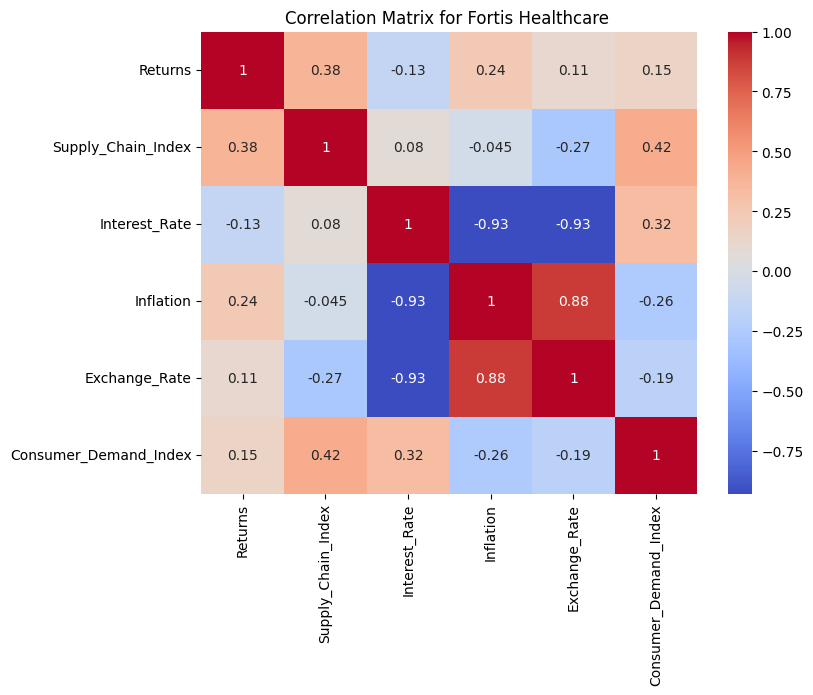

Correlation matrix for Dr Lal Pathlabs :
                         Returns  Supply_Chain_Index  Interest_Rate  Inflation  \
Returns                1.000000           -0.692834       0.003153  -0.173349   
Supply_Chain_Index    -0.692834            1.000000       0.080044  -0.044757   
Interest_Rate          0.003153            0.080044       1.000000  -0.927914   
Inflation             -0.173349           -0.044757      -0.927914   1.000000   
Exchange_Rate          0.042846           -0.273747      -0.925206   0.881930   
Consumer_Demand_Index -0.494168            0.420783       0.322289  -0.256197   

                       Exchange_Rate  Consumer_Demand_Index  
Returns                     0.042846              -0.494168  
Supply_Chain_Index         -0.273747               0.420783  
Interest_Rate              -0.925206               0.322289  
Inflation                   0.881930              -0.256197  
Exchange_Rate               1.000000              -0.185029  
Consumer_Demand_In

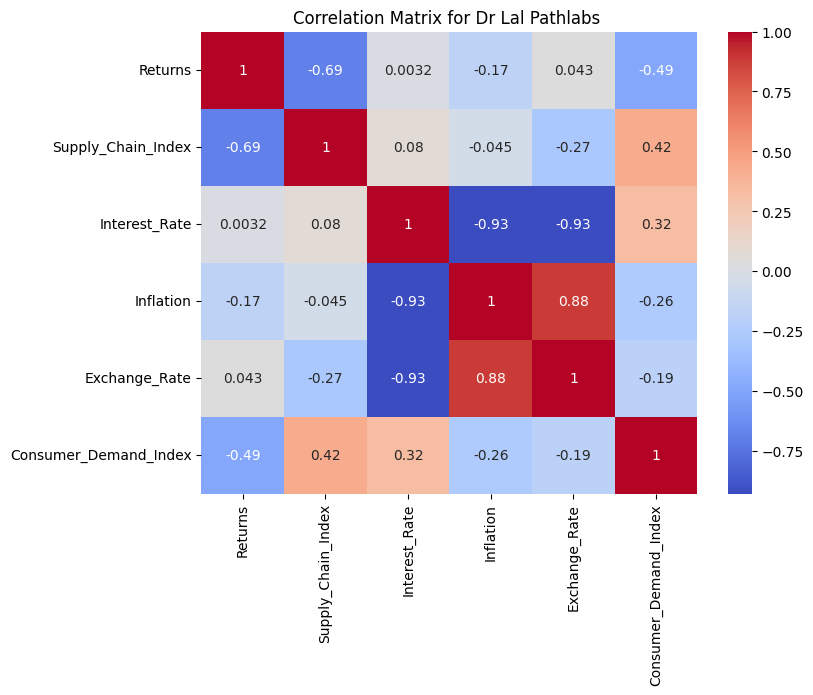

Correlation matrix for Global Health :
                        Returns  Supply_Chain_Index  Interest_Rate  Inflation  \
Returns                    NaN                 NaN            NaN        NaN   
Supply_Chain_Index         NaN                 NaN            NaN        NaN   
Interest_Rate              NaN                 NaN            NaN        NaN   
Inflation                  NaN                 NaN            NaN        NaN   
Exchange_Rate              NaN                 NaN            NaN        NaN   
Consumer_Demand_Index      NaN                 NaN            NaN        NaN   

                       Exchange_Rate  Consumer_Demand_Index  
Returns                          NaN                    NaN  
Supply_Chain_Index               NaN                    NaN  
Interest_Rate                    NaN                    NaN  
Inflation                        NaN                    NaN  
Exchange_Rate                    NaN                    NaN  
Consumer_Demand_Index      

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


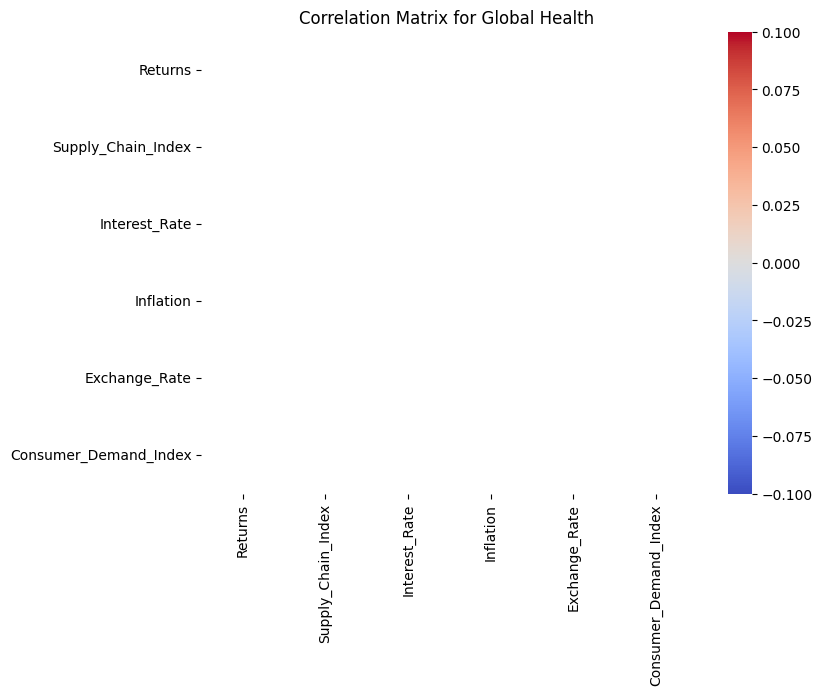

Correlation matrix for Metropolis Healthcare:
                         Returns  Supply_Chain_Index  Interest_Rate  Inflation  \
Returns                1.000000           -0.411151      -0.125033   0.267994   
Supply_Chain_Index    -0.411151            1.000000       0.007659   0.029058   
Interest_Rate         -0.125033            0.007659       1.000000  -0.891762   
Inflation              0.267994            0.029058      -0.891762   1.000000   
Exchange_Rate          0.154173           -0.257121      -0.887594   0.836263   
Consumer_Demand_Index -0.415412            0.412251       0.137498  -0.076613   

                       Exchange_Rate  Consumer_Demand_Index  
Returns                     0.154173              -0.415412  
Supply_Chain_Index         -0.257121               0.412251  
Interest_Rate              -0.887594               0.137498  
Inflation                   0.836263              -0.076613  
Exchange_Rate               1.000000               0.059211  
Consumer_Dema

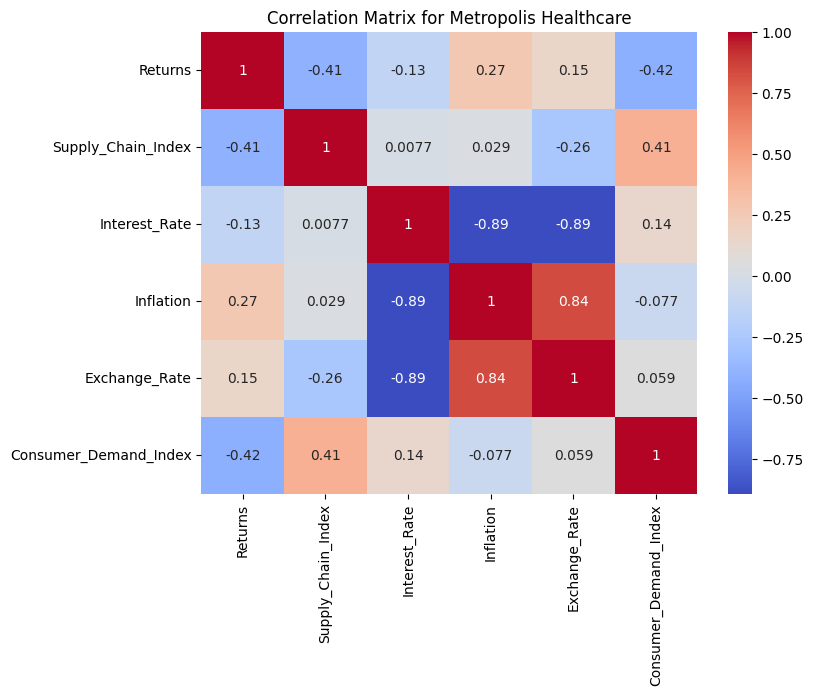

Correlation matrix for Krishna Institute :
                         Returns  Supply_Chain_Index  Interest_Rate  Inflation  \
Returns                1.000000            0.545475       0.621279  -0.226710   
Supply_Chain_Index     0.545475            1.000000      -0.150558   0.686593   
Interest_Rate          0.621279           -0.150558       1.000000  -0.643594   
Inflation             -0.226710            0.686593      -0.643594   1.000000   
Exchange_Rate         -0.388095            0.190449      -0.932435   0.458742   
Consumer_Demand_Index  0.203429            0.739349      -0.640443   0.604193   

                       Exchange_Rate  Consumer_Demand_Index  
Returns                    -0.388095               0.203429  
Supply_Chain_Index          0.190449               0.739349  
Interest_Rate              -0.932435              -0.640443  
Inflation                   0.458742               0.604193  
Exchange_Rate               1.000000               0.776264  
Consumer_Demand_

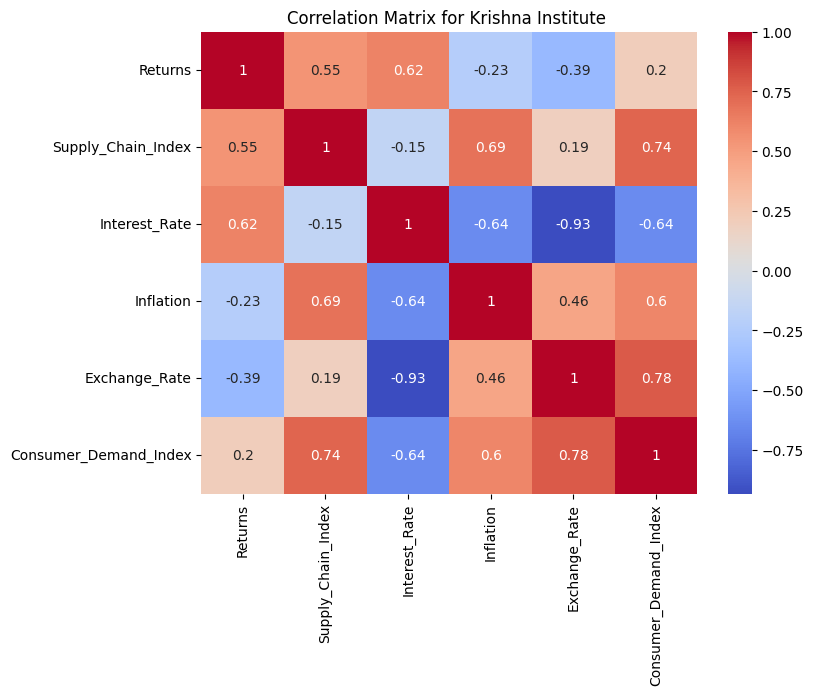

Correlation matrix for Thyrocare:
                         Returns  Supply_Chain_Index  Interest_Rate  Inflation  \
Returns                1.000000            0.268939      -0.177520   0.295827   
Supply_Chain_Index     0.268939            1.000000       0.080044  -0.044757   
Interest_Rate         -0.177520            0.080044       1.000000  -0.927914   
Inflation              0.295827           -0.044757      -0.927914   1.000000   
Exchange_Rate          0.246328           -0.273747      -0.925206   0.881930   
Consumer_Demand_Index  0.118718            0.420783       0.322289  -0.256197   

                       Exchange_Rate  Consumer_Demand_Index  
Returns                     0.246328               0.118718  
Supply_Chain_Index         -0.273747               0.420783  
Interest_Rate              -0.925206               0.322289  
Inflation                   0.881930              -0.256197  
Exchange_Rate               1.000000              -0.185029  
Consumer_Demand_Index    

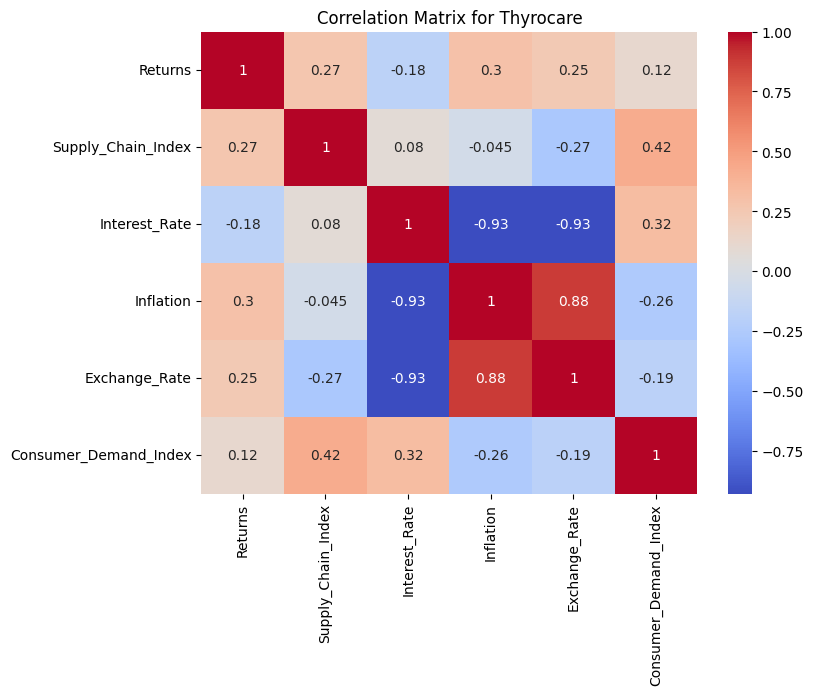

Correlation matrix for Divis :
                         Returns  Supply_Chain_Index  Interest_Rate  Inflation  \
Returns                1.000000           -0.736127      -0.392412   0.356763   
Supply_Chain_Index    -0.736127            1.000000       0.080044  -0.044757   
Interest_Rate         -0.392412            0.080044       1.000000  -0.927914   
Inflation              0.356763           -0.044757      -0.927914   1.000000   
Exchange_Rate          0.440723           -0.273747      -0.925206   0.881930   
Consumer_Demand_Index -0.656009            0.420783       0.322289  -0.256197   

                       Exchange_Rate  Consumer_Demand_Index  
Returns                     0.440723              -0.656009  
Supply_Chain_Index         -0.273747               0.420783  
Interest_Rate              -0.925206               0.322289  
Inflation                   0.881930              -0.256197  
Exchange_Rate               1.000000              -0.185029  
Consumer_Demand_Index      -

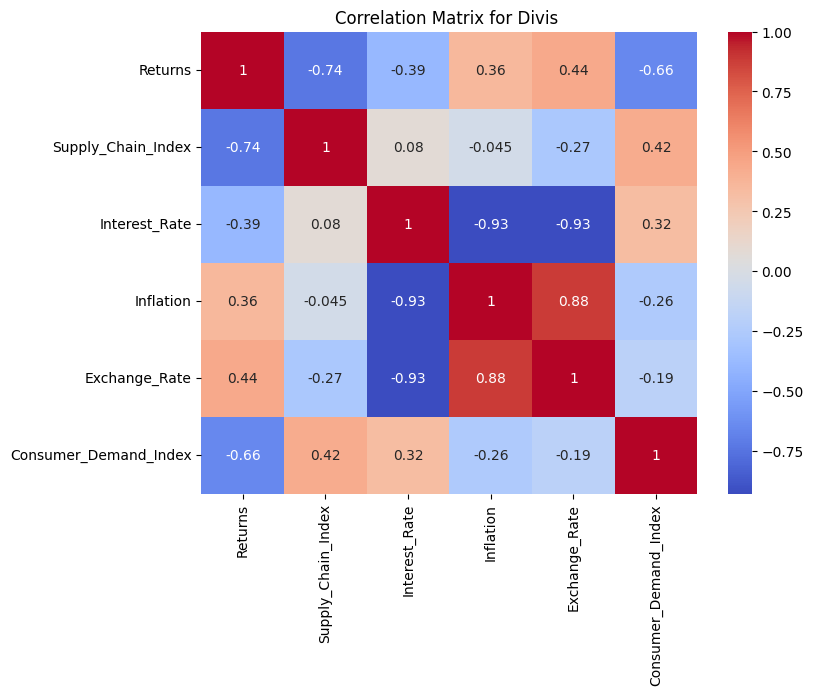

In [30]:
# Checking for multicollinearity
import seaborn as sns
import matplotlib.pyplot as plt

for stock, data in combined_data.items():
    data = data.dropna()

    # Correlation matrix
    correlation_matrix = data[['Returns', 'Supply_Chain_Index', 'Interest_Rate', 'Inflation', 'Exchange_Rate','Consumer_Demand_Index']].corr()
    print(f"Correlation matrix for {stock}:\n", correlation_matrix)

    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title(f'Correlation Matrix for {stock}')
    plt.show()
